# Assignment nº2
## Stock Portfolio Forecasting and Optimization on S&P500 Using Machine Learning and Search Methods
### Laboratory of Artificial Intelligence and Data Science (2024/25)

##### Work assembled by Alejandro Gonçalves (202205564), Francisca Mihalache (202206022), João Sousa (202205238) and Vítor Ferreira (201109428).

## Table of contents <a name="contents"></a>

1. [Introduction](#introduction)
2. [Business Understanding](#business)
3. [Data Understanding](#data_understanding)
4. [Data Preparation](#data_preparation)
5. [Modeling](#modeling)
   - 5.1. [XGBoost: Aggregated Approach](#xgbr_aggregated)
   - 5.2. [XGBoost: Dedicated Approach](#xgbr_dedicated)
   - 5.3. [Random Forest: Aggregated Approach](#rf_aggregated)
   - 5.4. [Random Forest: Dedicated Approach](#rf_dedicated)
   - 5.5. [Model Selection](#model_selection)
7. [Evaluation](#evaluation)
8. [Optimization](#optimization)
9. [Conclusion](#conclusion)
10. [References](#references)

In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import time
import joblib
from tqdm.notebook import tqdm
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
from scipy.optimize import minimize
from itertools import combinations
from scipy.stats import norm

## 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The primary objective of this project is to develop a comprehensive system for **predicting stock prices** and **optimizing portfolio allocation** in the S&P 500 market, which could aid in investment decision-making while managing associated risks. This dual-purpose approach combines forecasting accuracy with practical portfolio management constraints.

To ensure a systematic and efficient approach, we will follow the **CRISP-DM** (Cross-Industry Standard Process for Data Mining) framework. CRISP-DM is a widely adopted methodology that consists of six phases: Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, and Deployment. For the purposes of our project, we will follow the first 5 phases and will add a final one called "Optimization".

Given the financial nature of this project, special attention will be paid to:

1. Avoiding look-ahead bias in our predictions
2. Incorporating trading constraints 
3. Balancing return maximization with risk management

Our implementation will cover the development and evaluation of the strategy, with the final performance assessment conducted on January 2024 data. 

## 2. Business Understanding <a name="business"></a>
[[go back to the top]](#contents)

The stock market's complexity and volatility present significant challenges for investors seeking consistent returns. This volatility, combined with factors like geopolitical events, economic cycles, and company-specific news, makes precise market prediction particularly challenging.

**Traditional investment strategies** often rely heavily on fundamental analysis and human judgment, which can be subject to emotional biases and limited processing capacity when dealing with large amounts of market data. While these approaches have merit, they may miss subtle patterns and relationships in market movements that could be identified through systematic analysis. To address these limitations, **algorithmic trading systems** have emerged as powerful tools for making data-driven investment decisions, potentially improving both the speed and objectivity of market analysis **[1]**.

A promising direction in algorithmic trading is the application of **machine learning** techniques to both forecast price movements and optimize portfolio allocation. These approaches can process vast amounts of historical market data to identify patterns and relationships that might not be apparent through traditional analysis **[2]**. Moreover, the combination of predictive modeling with portfolio optimization techniques allows for a systematic approach to managing investment risks while seeking returns **[3]**. This is particularly relevant given that studies show the underperformance of large equity managers. For instance, in the first six months of 2023, 60% of all active large-cap U.S. equity managers underperformed the S&P 500 **[4]**.

Thus, the project's scope encompasses building a comprehensive system that operates within specific constraints: an initial capital of **10 000 USD** a maximum daily purchase limit of **100 stocks**, and a transaction cost of **1 USD per stock** bought. These parameters reflect realistic trading conditions.

## 3. Data Understanding <a name="data_understanding"></a>
[[go back to the top]](#contents)

We'll start by collecting historical stock data for S&P 500 companies, following this methodology:

**Time Period**: 
- January 2010 to January 2024

**Data Sources**:
- Stock data: Yahoo Finance API (yfinance)
- S&P 500 components: Wikipedia's current list

**Data Collection Process**:
- Downloads complete historical data for each S&P 500 stock
- Requires complete coverage 
- Handles special symbols (e.g., BRK.B → BRK-B)
- Adds sector and industry information from S&P 500 list

**Output Files**:
- sp500_full_data.csv: Complete historical data
- stock_analysis.csv: Summary statistics per stock including: Average volume, Average price, Volatility, Sector/Industry classification

In [3]:
# Settings and Constants
START_DATE = '2010-01-01'
END_DATE = '2024-01-31'

def clean_ticker(ticker):
    """Clean ticker symbols that have special characters"""
    if '.' in ticker:
        return ticker.replace('.', '-')
    return ticker

def get_sp500_tickers():
    """Get current S&P 500 tickers from Wikipedia"""
    try:
        sp500_wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
        return sp500_wiki[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
    except Exception as e:
        print(f"Error getting S&P 500 tickers: {e}")
        return None

def download_stock_data(ticker, start_date, end_date, sleep_time=1):
    """Download historical data for a single stock"""
    cleaned_ticker = clean_ticker(ticker)
    try:
        stock = yf.Ticker(cleaned_ticker)
        df = stock.history(start=start_date, end=end_date)
        
        if not df.empty:
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Keep only relevant columns
            df['Symbol'] = ticker  # Keep original ticker for reference
            df.index = df.index.normalize()  # Normalize dates to remove time component
            time.sleep(sleep_time)
            return df
        else:
            print(f"No data found for {ticker}")
            return None
            
    except Exception as e:
        print(f"Error downloading {ticker}: {str(e)}")
        return None

def collect_sp500_data():
    """Collect data for S&P 500 stocks with complete coverage"""
    # Create data directory if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Get S&P 500 components
    sp500_info = get_sp500_tickers()
    if sp500_info is None:
        return None
    
    tickers = sp500_info['Symbol'].tolist()
    print(f"Total number of stocks to process: {len(tickers)}")
    
    # Initialize storage
    all_data = pd.DataFrame()
    expected_rows = 3542  # Number of trading days in the period
    
    # Download data with progress bar
    for ticker in tqdm(tickers, desc="Downloading stock data"):
        stock_data = download_stock_data(ticker, START_DATE, END_DATE)
        
        if stock_data is not None and len(stock_data) == expected_rows:  # Only keep stocks with complete coverage
            # Add sector and industry information
            stock_info = sp500_info[sp500_info['Symbol'] == ticker].iloc[0]
            stock_data['Sector'] = stock_info['GICS Sector']
            stock_data['Industry'] = stock_info['GICS Sub-Industry']
            
            # Add to main DataFrame
            all_data = pd.concat([all_data, stock_data])
    
    if not all_data.empty:
        # Save complete dataset
        all_data.to_csv('data/sp500_full_data.csv', date_format='%Y-%m-%d')
        
        # Generate and save stock analysis
        stock_analysis = pd.DataFrame()
        for symbol in all_data['Symbol'].unique():
            stock_data = all_data[all_data['Symbol'] == symbol]
            stock_analysis.loc[symbol, 'Sector'] = stock_data['Sector'].iloc[0]
            stock_analysis.loc[symbol, 'Industry'] = stock_data['Industry'].iloc[0]
            stock_analysis.loc[symbol, 'Average_Volume'] = stock_data['Volume'].mean()
            stock_analysis.loc[symbol, 'Average_Price'] = stock_data['Close'].mean()
            stock_analysis.loc[symbol, 'Volatility'] = stock_data['Close'].pct_change().std() * 100
            
        stock_analysis.to_csv('data/stock_analysis.csv')
        
        print(f"\nSuccessfully processed {len(all_data['Symbol'].unique())} stocks")
        print(f"Files saved: sp500_full_data.csv, stock_analysis.csv")
        return all_data
    
    print("\nNo data was collected successfully")
    return None

# Execute the data collection
print("Starting S&P 500 data collection...")
all_data = collect_sp500_data()

if all_data is not None:
    print("\nData collection completed!")

Starting S&P 500 data collection...
Total number of stocks to process: 503


No data found for AMTM


No data found for GEV


No data found for SW


No data found for SOLV



Successfully processed 430 stocks
Files saved: sp500_full_data.csv, stock_analysis.csv

Data collection completed!


From the initial 500 stocks, we gathered **430 stocks** that had complete trading data from **Jaunary 2010 to January 2024**. We then explored their distribution across sectors and industries to understand our dataset composition.

In [7]:
# Load the stock analysis data
analysis = pd.read_csv('data/stock_analysis.csv', index_col=0)

# Print the number of industries and sub-industries
num_sectors = analysis['Sector'].nunique()
num_industries = analysis['Industry'].nunique()

print(f"Number of Sectors: {num_sectors}")
print(f"Number of Sub-Industries: {num_industries}")

Number of Sectors: 11
Number of Sub-Industries: 120


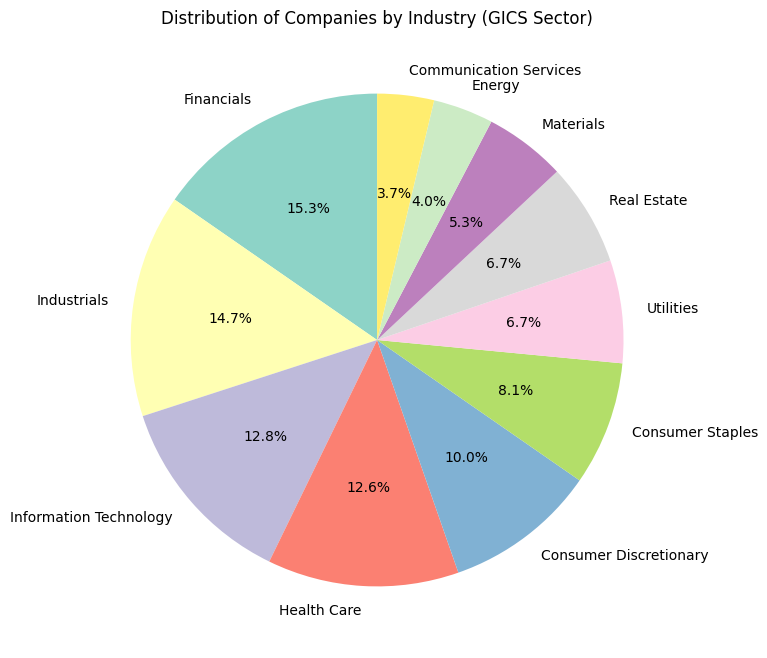

In [6]:
# Industry distribution
industry_counts = analysis['Sector'].value_counts()

# Plot pie chart for industries
plt.figure(figsize=(10, 8))
industry_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.title("Distribution of Companies by Industry (GICS Sector)")
plt.ylabel("")  
plt.show()

Key sectors are: **Financials** (15.3%), **Industrials** (14.7%), and **Information Technology** (12.8%).

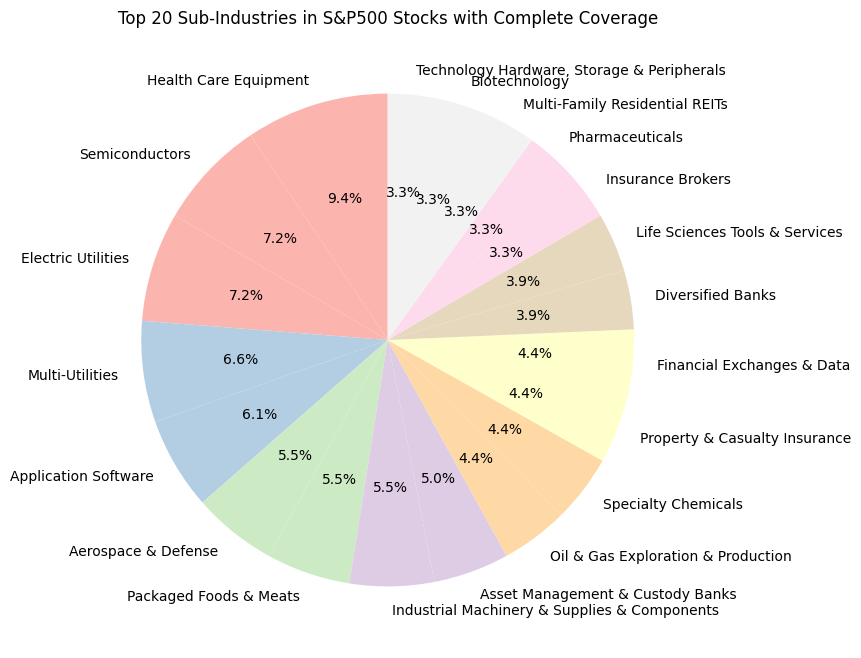

In [7]:
sub_industry_counts = analysis['Industry'].value_counts().head(20)  # Top 20 sub-industries

plt.figure(figsize=(10, 8))
sub_industry_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title("Top 20 Sub-Industries in S&P500 Stocks with Complete Coverage")
plt.ylabel("")
plt.show()

Regarding the Sub-Industries: Health Care Equipment leads with 9.4%, followed by Electric Utilities and Semiconductors (7.2% each). We can see that the top 20 sub-industries represent diverse sectors, from technology to utilities, and financial services.

## 4. Data Preparation <a name="data_preparation"></a>
[[go back to the top]](#contents)

Our preprocessing strategy focuses on creating a robust dataset for predicting **next-day** stock prices **(close)** using only information available at prediction time. Here's our approach:

**Data Structure**
- We work with daily stock data including **OHLCV** (Open, High, Low, Close, Volume) prices
- Each stock includes **sector** and **industry** classification
- Our goal is to predict tomorrow's close prices using only information available at today's close.

**Technical Indicators**: We calculate several technical indicators using the closing price, as this represents the most recent information available when making predictions:

**Trend Indicators**:
- Simple Moving Averages (10 and 20 days)
- Exponential Moving Average (10 days)
- MACD (Moving Average Convergence Divergence)

**Momentum Indicators**:
- RSI (Relative Strength Index)
- Daily Returns
- 5-day Returns

**Volatility Indicators**:
- Bollinger Bands Width

**Volume Indicators**:
- Volume RSI

**Sector-Level Analysis**: To capture market-wide trends and sector-specific behavior, we calculate several sector-level statistics:
- Mean, minimum, maximum, and standard deviation of:
- Daily returns per sector
- 5-day returns per sector

The **preprocessing pipeline**:
- Loads raw stock data
- Calculates technical indicators for each stock
- Computes sector-level statistics
- Merges all features into a final dataset
- Handles missing values appropriately

In [ ]:
def load_data():
    """Load and perform initial data quality check"""
    data = pd.read_csv('data/sp500_full_data.csv', index_col=0, parse_dates=True)
    print(f"Data shape: {data.shape}")
    print(f"Missing values: {data.isnull().sum().sum()}")
    return data

def calculate_technical_indicators(df, symbol):
    """Calculate technical indicators for a single stock"""
    stock_data = df[df['Symbol'] == symbol].copy()
    close_price = stock_data['Close']
    
    # Trend Indicators
    stock_data['SMA_10'] = SMAIndicator(close_price, window=10).sma_indicator()
    stock_data['SMA_20'] = SMAIndicator(close_price, window=20).sma_indicator()
    stock_data['EMA_10'] = EMAIndicator(close_price, window=10).ema_indicator()
    
    # MACD
    macd = MACD(close_price)
    stock_data['MACD'] = macd.macd()
    
    # RSI
    stock_data['RSI'] = RSIIndicator(close_price).rsi()
    
    # Bollinger Bands Width
    bb = BollingerBands(close_price)
    stock_data['BB_Width'] = (bb.bollinger_hband() - bb.bollinger_lband()) / stock_data['SMA_20']
    
    # Returns
    stock_data['Daily_Return'] = close_price.pct_change()
    stock_data['5d_Return'] = close_price.pct_change(5)
    
    # Volume RSI
    stock_data['Volume_RSI'] = RSIIndicator(stock_data['Volume']).rsi()
    
    return stock_data

def calculate_sector_indicators(df):
    """Calculate sector-level statistics"""
    sector_daily_stats = df.groupby(['Date', 'Sector']).agg({
        'Daily_Return': ['mean', 'min', 'max', 'std'],
        '5d_Return': ['mean', 'min', 'max', 'std']
    })
    
    sector_daily_stats.columns = [
        'Sector_Mean_Daily_Return', 'Sector_Min_Daily_Return',
        'Sector_Max_Daily_Return', 'Sector_Std_Daily_Return',
        'Sector_Mean_5d_Return', 'Sector_Min_5d_Return',
        'Sector_Max_5d_Return', 'Sector_Std_5d_Return'
    ]
    
    return sector_daily_stats.reset_index()

def process_all_stocks(data):
    """Process all stocks and create features"""
    processed_data = pd.DataFrame()
    symbols = data['Symbol'].unique()
    
    print("Processing stocks:")
    for symbol in tqdm(symbols):
        processed_stock = calculate_technical_indicators(data, symbol)
        processed_data = pd.concat([processed_data, processed_stock])
    
    # Drop rows with missing values after indicators are computed
    processed_data.dropna(inplace=True)
    
    # Calculate sector indicators
    sector_indicators = calculate_sector_indicators(processed_data)
    
    # Merge sector indicators back to the main dataset
    processed_data = processed_data.merge(sector_indicators, on=['Date', 'Sector'], how='left')
    
    return processed_data

# Execute processing pipeline
print("Starting data preprocessing...")
data = load_data()
processed_data = process_all_stocks(data)

# Save the fully processed data
processed_data.to_csv('data/processed_full_data.csv')
print("Processing complete. Data saved to 'data/processed_full_data.csv'")

# Print final data info
print("\nFinal dataset information:")
print(f"Shape: {processed_data.shape}")
print("\nFeatures available:")
print(processed_data.columns.tolist())

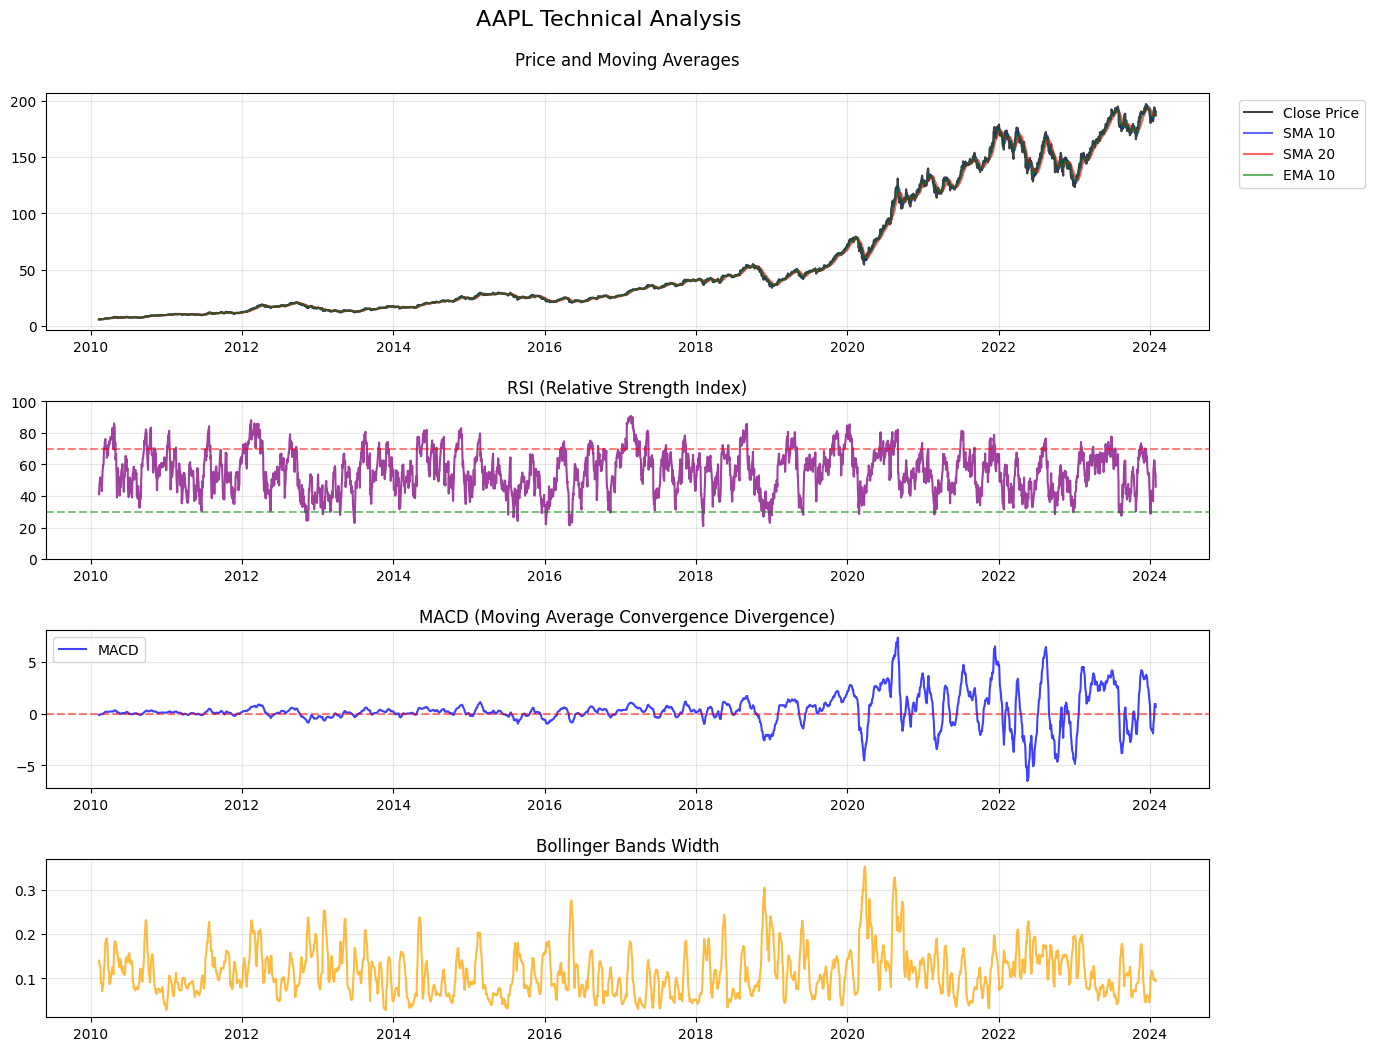

In [4]:
# Load the processed data
df = pd.read_csv('data/processed_full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Filter for AAPL
aapl_data = df[df['Symbol'] == 'AAPL'].copy()
aapl_data.set_index('Date', inplace=True)

# Create the visualization
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(4, 1, height_ratios=[1.5, 1, 1, 1], hspace=0.4)
fig.suptitle('AAPL Technical Analysis', fontsize=16, y=0.95)

# Plot 1: Price and Moving Averages
ax1 = fig.add_subplot(gs[0])
ax1.plot(aapl_data.index, aapl_data['Close'], label='Close Price', color='black', alpha=0.75)
ax1.plot(aapl_data.index, aapl_data['SMA_10'], label='SMA 10', color='blue', alpha=0.6)
ax1.plot(aapl_data.index, aapl_data['SMA_20'], label='SMA 20', color='red', alpha=0.6)
ax1.plot(aapl_data.index, aapl_data['EMA_10'], label='EMA 10', color='green', alpha=0.6)
ax1.set_title('Price and Moving Averages', pad=20)  
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1)) 
ax1.grid(True, alpha=0.3)

# Plot 2: RSI
ax2 = fig.add_subplot(gs[1])
ax2.plot(aapl_data.index, aapl_data['RSI'], color='purple', alpha=0.75)
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
ax2.set_title('RSI (Relative Strength Index)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# Plot 3: MACD
ax3 = fig.add_subplot(gs[2])
ax3.plot(aapl_data.index, aapl_data['MACD'], color='blue', label='MACD', alpha=0.75)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('MACD (Moving Average Convergence Divergence)')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')

# Plot 4: Bollinger Bands Width
ax4 = fig.add_subplot(gs[3])
ax4.plot(aapl_data.index, aapl_data['BB_Width'], color='orange', alpha=0.75)
ax4.set_title('Bollinger Bands Width')
ax4.grid(True, alpha=0.3)

plt.show()

The graphs above shows a comprehensive technical analysis of **Apple stock** from 2010 to 2024, displaying several key technical indicators that we've calculated in our preprocessing phase:

- The top panel shows the **stock price** (black line) along with various **moving averages** (SMA 10, SMA 20, and EMA 10), which help identify trends and potential support/resistance levels.
- The **RSI indicator** (purple) oscillates between 0 and 100, with traditional **overbought (70)** and **oversold (30)** levels marked by dashed lines.
- The **MACD** (blue) helps identify **momentum changes** and potential **trend reversals**.
- The **Bollinger Bands Width** (orange) shows periods of high and low **volatility** in the stock price.

These indicators form part of our feature set for predicting next-day close prices. We can also notice how the **volatility** and trading patterns changed significantly **after 2020**.

Loading data...

Market Overview:
Total stocks analyzed: 430
Sectors: 11
Industries: 120


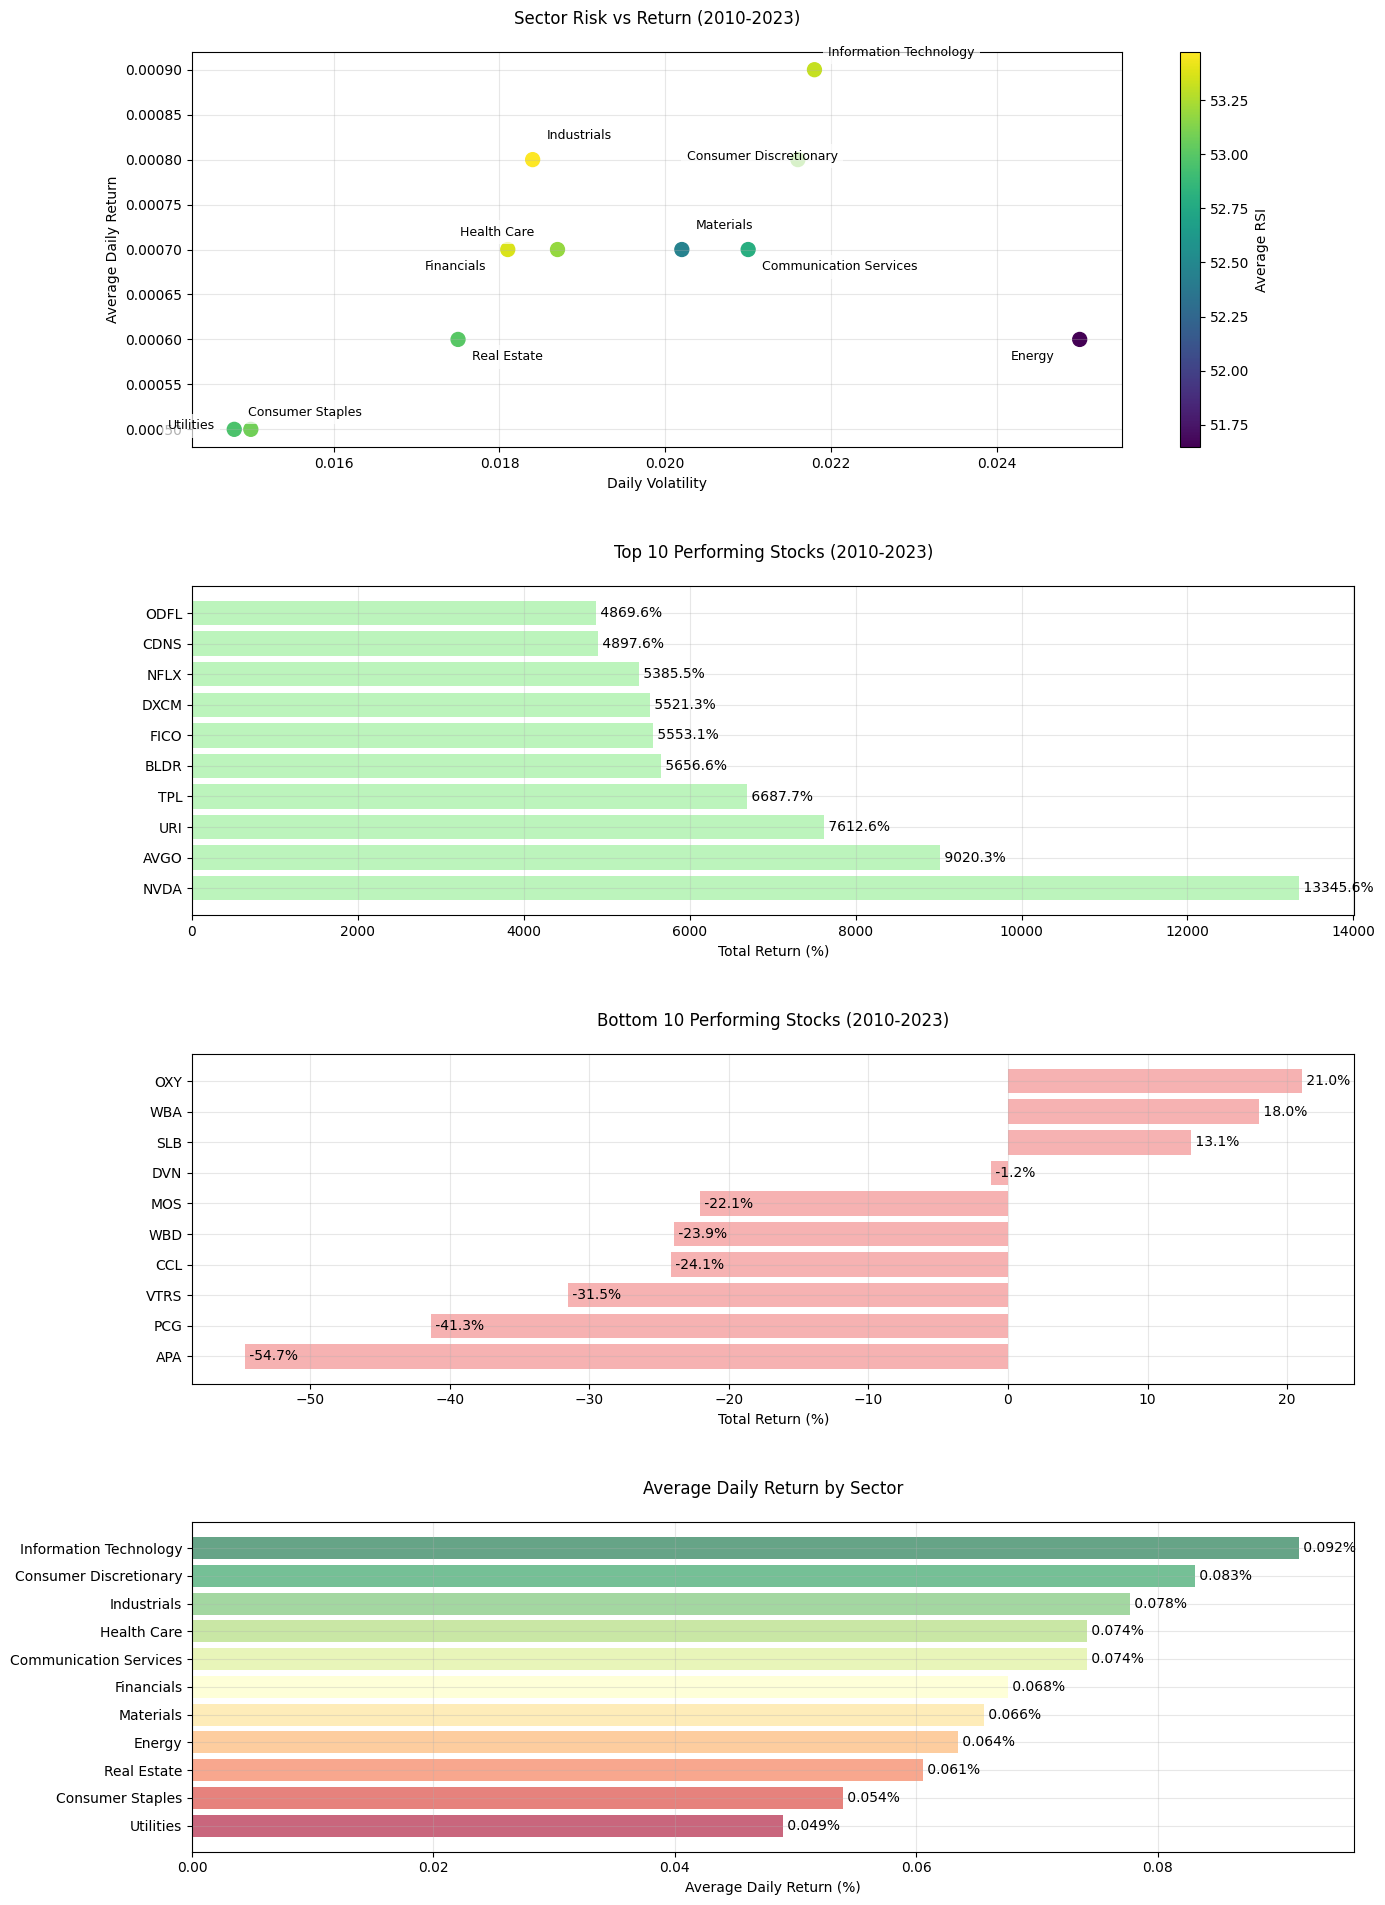

In [6]:
def adjust_text_positions(ax, points, texts, sector_names):
   """Manual adjustment of text positions to avoid overlap"""
   # Define some offset multipliers for specific sectors
   offsets = {
       'Information Technology': (10, 10),
       'Consumer Discretionary': (-80, 0),
       'Communication Services': (10, -15),
       'Health Care': (-70, 10),
       'Financials': (-60, -15),
       'Materials': (10, 15),
       'Real Estate': (10, -15),
       'Consumer Staples': (10, 10),
       'Utilities': (-60, 0),
       'Industrials': (10, 15),
       'Energy': (-50, -15)
   }
   
   for idx, sector in enumerate(sector_names):
       point = points.loc[sector]
       offset_x, offset_y = offsets.get(sector, (5, 5))
       ax.annotate(sector, 
                   (point['Daily_Volatility'], point['Avg_Daily_Return']),
                   xytext=(offset_x, offset_y), 
                   textcoords='offset points',
                   fontsize=9,
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

def analyze_market():
   """Analyze stock market performance including sector and industry analysis"""
   # Load data
   print("Loading data...")
   processed_data = pd.read_csv('data/processed_full_data.csv')
   processed_data['Date'] = pd.to_datetime(processed_data['Date'])
   
   # Filter for training period (up to December 2023)
   train_mask = processed_data['Date'] < '2024-01-01'
   processed_train = processed_data[train_mask].copy()
   
   print("\nMarket Overview:")
   print(f"Total stocks analyzed: {processed_train['Symbol'].nunique()}")
   print(f"Sectors: {processed_train['Sector'].nunique()}")
   print(f"Industries: {processed_train['Industry'].nunique()}")
   
   # Calculate total returns for the period
   first_prices = processed_train.groupby('Symbol')['Close'].first()
   last_prices = processed_train.groupby('Symbol')['Close'].last()
   total_returns = ((last_prices - first_prices) / first_prices * 100).round(2)
   
   # Calculate sector statistics
   sector_stats = processed_train.groupby('Sector').agg({
       'Daily_Return': ['mean', 'std'],
       'RSI': 'mean',
       'Volume': 'mean'
   }).round(4)
   sector_stats.columns = ['Avg_Daily_Return', 'Daily_Volatility', 'Avg_RSI', 'Avg_Volume']
   
   # Create figure
   fig = plt.figure(figsize=(15, 20))
   gs = GridSpec(4, 1, height_ratios=[1.2, 1, 1, 1], hspace=0.4)
   
   # Plot 1: Sector Risk-Return Analysis
   ax1 = fig.add_subplot(gs[0])
   scatter = ax1.scatter(sector_stats['Daily_Volatility'], 
                        sector_stats['Avg_Daily_Return'],
                        s=100,
                        c=sector_stats['Avg_RSI'],
                        cmap='viridis')
   
   adjust_text_positions(ax1, sector_stats, [], sector_stats.index)
   
   plt.colorbar(scatter, label='Average RSI')
   ax1.set_title('Sector Risk vs Return (2010-2023)', pad=20)
   ax1.set_xlabel('Daily Volatility')
   ax1.set_ylabel('Average Daily Return')
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Top 10 Performing Stocks
   ax2 = fig.add_subplot(gs[1])
   top_10 = total_returns.nlargest(10)
   bars = ax2.barh(range(len(top_10)), top_10.values, color='lightgreen', alpha=0.6)
   ax2.set_yticks(range(len(top_10)))
   ax2.set_yticklabels(top_10.index)
   ax2.set_title('Top 10 Performing Stocks (2010-2023)', pad=20)
   ax2.set_xlabel('Total Return (%)')
   ax2.grid(True, alpha=0.3)
   
   # Add value labels
   for i, v in enumerate(top_10.values):
       ax2.text(v, i, f' {v:.1f}%', va='center')
   
   # Plot 3: Bottom 10 Performing Stocks
   ax3 = fig.add_subplot(gs[2])
   bottom_10 = total_returns.nsmallest(10)
   bars = ax3.barh(range(len(bottom_10)), bottom_10.values, color='lightcoral', alpha=0.6)
   ax3.set_yticks(range(len(bottom_10)))
   ax3.set_yticklabels(bottom_10.index)
   ax3.set_title('Bottom 10 Performing Stocks (2010-2023)', pad=20)
   ax3.set_xlabel('Total Return (%)')
   ax3.grid(True, alpha=0.3)
   
   # Add value labels
   for i, v in enumerate(bottom_10.values):
       ax3.text(v, i, f' {v:.1f}%', va='center')
   
   # Plot 4: Sector Performance Distribution
   ax4 = fig.add_subplot(gs[3])
   sector_returns = processed_train.groupby('Sector')['Daily_Return'].mean() * 100
   sector_returns = sector_returns.sort_values(ascending=True)
   
   colors = plt.cm.RdYlGn(np.linspace(0, 1, len(sector_returns)))
   bars = ax4.barh(range(len(sector_returns)), sector_returns.values, color=colors, alpha=0.6)
   ax4.set_yticks(range(len(sector_returns)))
   ax4.set_yticklabels(sector_returns.index)
   ax4.set_title('Average Daily Return by Sector', pad=20)
   ax4.set_xlabel('Average Daily Return (%)')
   ax4.grid(True, alpha=0.3)
   
   # Add value labels
   for i, v in enumerate(sector_returns.values):
       ax4.text(v, i, f' {v:.3f}%', va='center')
   
   plt.subplots_adjust(top=0.95, bottom=0.05)
   plt.show()
   

# Run the analysis
analyze_market()

From our market analysis of **S&P 500 stocks from 2010 to 2023**, we can observe interesting patterns in both individual stock performance and sector behavior:

**Top Performers**:
- **NVIDIA (NVDA)** leads with an exceptional return of 13,345%, demonstrating the **tremendous growth** in the semiconductor industry
- Other top performers include **AVGO (9,020%)** and **URI (7,612%)**, showing **strong returns** in **technology and industrial equipment** sectors
- Most of the top 10 stocks delivered **returns above 4,800%**, indicating **significant growth opportunities** in the market

**Worst Performers**:
- **APA** Corporation shows the largest decline (-54.7%), reflecting challenges in the energy sector
- Several **retail and energy companies** (PCG, VTRS, CCL) show significant **negative returns**
- Interesting to note that even **among the bottom performers**, some stocks like OXY, WBA, and SLB **managed to deliver positive returns**

**Sector Analysis**:
- **Information Technology** leads with the highest average daily return (0.092%)
- **Consumer Discretionary** and **Industrials** follow closely with 0.083% and 0.078% respectively
- **Utilities** shows the lowest average daily return (0.049%)
- **Defensive sectors** (Consumer Staples, Utilities) show **lower** but potentially more **stable** returns

## 5. Modeling <a name="modeling"></a>
[[go back to the top]](#contents)

Given our **regression task**, we will consider the **following strategy**:

**Phase 1: Model Selection**
- Use 5 validation periods to test different algorithms performance:
    - Train: 2010-2018, Validate: January 2019
    - Train: 2010-2019, Validate: January 2020
    - Train: 2010-2020, Validate: January 2021
    - Train: 2010-2021, Validate: January 2022
    - Train: 2010-2022, Validate: January 2023

- Models to Test: **XGBoost**, **Random Forest**
- Evaluation Metrics: **MAE**, **RMSE**, **MAPE**
- Goal: Identify the **best performing algorithm** based on average performance across all validation periods

For each algorithm, we will evaluate based on two approaches, one **aggregated** and one **dedicated**:
- The **aggregated** approach involves training a single model using the **data from all stocks combined**. This approach uses the broader dataset to generalize patterns across different stocks and predict outcomes for each stock based on the shared model. It is designed to benefit from the collective information and relationships present across the entire dataset.
- The **dedicated approach**, on the other hand, involves training a **separate model for each individual stock**. This approach focuses on stock-specific information, tailoring the model to the unique characteristics and behaviors of each stock. 

**Phase 2: Final Model Development**
- Training Period: January 2010 - December 2023
- Test Period: January 2024
- Model: Best performing algorithm from Phase 1
- Goal: Final evaluation of model performance using completely unseen data

**Features and Targets**
- Use all technical indicators and sector information metrics as features
- Predict next day's Close prices for all stocks

This **two-phase approach** ensures proper model selection and unbiased final evaluation while maximizing the use of available historical data for the final predictions.

Due to the **scale of the data** (over 1 million rows in the dataset, with 14 years of data for 430 stocks), it was essential to choose models that offered a balance between performance and speed. The models selected (XGBoost **[5]** and Random Forest) are known for their efficiency in handling large datasets and their ability to produce fast predictions. This was a critical consideration given **the volume of data** and the need to evaluate **multiple folds** across validation periods.

### 5.1. XGBoost: Aggregated Approach <a name="xgbr_aggregated"></a>
[[go back to the top]](#contents)

In [25]:
def evaluate_model(full_data, feature_cols, model_class, train_end_date, eval_start_date, eval_end_date, model_type='aggregated'):
    """
    Train model and evaluate for a specific time window
    """
    # Convert dates to timestamps
    train_end_date = pd.Timestamp(train_end_date)
    eval_start_date = pd.Timestamp(eval_start_date)
    eval_end_date = pd.Timestamp(eval_end_date)
    
    # Ensure all feature columns are float64
    train_data = full_data[full_data['Date'] <= train_end_date].copy()
    train_data = train_data.dropna(subset=['Next_Close'])
    
    # Convert features to float64
    for col in feature_cols:
        train_data[col] = train_data[col].astype('float64')
    
    if model_type == 'aggregated':
        print(f"Training model up to {train_end_date.date()}...")
        # Add diagnostic information
        print(f"Training data shape: {train_data[feature_cols].shape}")
        print(f"Number of unique stocks: {train_data['Symbol'].nunique()}")
        print(f"Date range: {train_data['Date'].min()} to {train_data['Date'].max()}")
        
        with tqdm(total=2, desc='Training Progress') as pbar:
            X_train = train_data[feature_cols]
            y_train = train_data['Next_Close']
            pbar.update(1)
            
            if 'XGB' in model_class.__name__:
                model = model_class(
                    objective='reg:squarederror',
                    n_estimators=1000,
                    tree_method='hist',
                    enable_categorical=True,
                    verbose=True  
                )
            else:
                model = model_class(n_estimators=100, random_state=42)
            
            model.fit(X_train, y_train)
            pbar.update(1)
    
    # Make predictions for each stock
    all_predictions = []
    symbols = full_data['Symbol'].unique()
    
    with tqdm(total=len(symbols), desc='Processing Stocks') as pbar:
        for symbol in symbols:
            symbol_data = full_data[full_data['Symbol'] == symbol].sort_values('Date')
            
            if model_type == 'dedicated':
                train_symbol_data = symbol_data[symbol_data['Date'] <= train_end_date].copy()
                X_train = train_symbol_data[feature_cols]
                y_train = train_symbol_data['Next_Close']
                model = model_class(objective='reg:squarederror', n_estimators=100) if 'XGB' in model_class.__name__ else model_class(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)
            
            # Get the last day before evaluation period
            last_train_data = symbol_data[symbol_data['Date'] <= train_end_date].iloc[-1:]
            eval_data = symbol_data[
                (symbol_data['Date'] >= eval_start_date) & 
                (symbol_data['Date'] <= eval_end_date)
            ]
            
            prediction_data = pd.concat([last_train_data, eval_data])
            prediction_data = prediction_data.sort_values('Date')
            
            for col in feature_cols:
                prediction_data[col] = prediction_data[col].astype('float64')
            
            symbol_predictions = []
            for i in range(len(prediction_data) - 1):
                current_row = prediction_data.iloc[i]
                next_row = prediction_data.iloc[i + 1]
                
                if current_row[feature_cols].isnull().any():
                    continue
                
                X_pred = current_row[feature_cols].to_frame().T.astype('float64')
                pred_close = model.predict(X_pred)[0]
                
                symbol_predictions.append({
                    'Date': next_row['Date'],
                    'Symbol': symbol,
                    'Predicted_Close': pred_close,
                    'Actual_Close': next_row['Close']
                })
            
            all_predictions.extend(symbol_predictions)
            pbar.update(1)
    
    return pd.DataFrame(all_predictions)
    
def compute_metrics(predictions_df):
    """Compute metrics for all stocks"""
    metrics_list = []
    
    for symbol in predictions_df['Symbol'].unique():
        sym_data = predictions_df[predictions_df['Symbol'] == symbol]
        mask = sym_data['Actual_Close'].notnull() & sym_data['Predicted_Close'].notnull()
        actual = sym_data.loc[mask, 'Actual_Close']
        pred = sym_data.loc[mask, 'Predicted_Close']
        
        if len(actual) > 0:
            metrics_list.append({
                'Symbol': symbol,
                'RMSE': np.sqrt(((actual - pred)**2).mean()),
                'MAE': np.abs(actual - pred).mean(),
                'MAPE': np.abs((actual - pred) / actual).mean() * 100
            })
    
    return pd.DataFrame(metrics_list)

def run_experiment(model_class, model_type, df, feature_cols, folds):
    """Run complete experiment for a specific model and type"""
    model_name = model_class.__name__
    approach_name = f"{model_type}_{model_name.lower()}"
    
    print(f"\nRunning {approach_name} approach...")
    
    all_fold_metrics = []
    
    for i, fold in enumerate(folds, start=1):
        print(f"\n*** Running Fold {i} ***")
        start_time = time.time()
        
        validation_predictions = evaluate_model(
            df, 
            feature_cols,
            model_class,
            train_end_date=fold['train_end_date'],
            eval_start_date=fold['eval_start_date'],
            eval_end_date=fold['eval_end_date'],
            model_type=model_type
        )
        # Compute metrics for this fold
        validation_metrics = compute_metrics(validation_predictions)
        
        # Extract the year for naming
        eval_year = pd.to_datetime(fold['eval_start_date']).year
        
        # Save predictions and metrics
        validation_predictions.to_csv(f'validation/{approach_name}_predictions_january_{eval_year}.csv', index=False)
        validation_metrics.to_csv(f'validation/{approach_name}_metrics_january_{eval_year}.csv', index=False)
        
        # Add fold information
        validation_metrics['Fold'] = i
        validation_metrics['Train_End_Date'] = fold['train_end_date']
        validation_metrics['Eval_Start_Date'] = fold['eval_start_date']
        validation_metrics['Eval_End_Date'] = fold['eval_end_date']
        
        all_fold_metrics.append(validation_metrics)
        
        end_time = time.time()
        print(f"\nFold {i} completed in {(end_time - start_time)/60:.2f} minutes")
        print(f"Fold {i} Summary Statistics:")
        print(f"Average RMSE: {validation_metrics['RMSE'].mean():.2f}")
        print(f"Average MAE: {validation_metrics['MAE'].mean():.2f}")
        print(f"Average MAPE: {validation_metrics['MAPE'].mean():.2f}")
    
    # Combine all metrics
    all_metrics_df = pd.concat(all_fold_metrics, ignore_index=True)
    all_metrics_df.to_csv(f'validation/{approach_name}_all_folds_metrics.csv', index=False)
    
    print(f"\nOverall Summary Statistics for {approach_name}:")
    print(f"Average RMSE across all folds: {all_metrics_df['RMSE'].mean():.2f}")
    print(f"Average MAE across all folds: {all_metrics_df['MAE'].mean():.2f}")
    print(f"Average MAPE across all folds: {all_metrics_df['MAPE'].mean():.2f}")

In [26]:
df = pd.read_csv('data/processed_full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Define numeric columns
numeric_columns = [
    'Open', 'Close', 'High', 'Low', 'Volume', 
    'SMA_10', 'SMA_20', 'EMA_10', 'MACD', 'RSI', 
    'BB_Width', 'Daily_Return', '5d_Return', 'Volume_RSI',
    'Sector_Mean_Daily_Return', 'Sector_Min_Daily_Return',
    'Sector_Max_Daily_Return', 'Sector_Std_Daily_Return',
    'Sector_Mean_5d_Return', 'Sector_Min_5d_Return',
    'Sector_Max_5d_Return', 'Sector_Std_5d_Return'
]

# Convert columns to float64 and replace any invalid values with NaN
for col in numeric_columns:
    # First replace any empty strings or invalid values with NaN
    df[col] = df[col].replace(['', 'null', 'NaN', 'inf', '-inf'], np.nan)
    # Then convert to float64
    df[col] = df[col].astype('float64')

# Create target variable
if 'Next_Close' not in df.columns:
    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1).astype('float64')

# Define features
feature_cols = numeric_columns  

# Define folds
folds = [
    {
        'train_end_date': '2018-12-31',
        'eval_start_date': '2019-01-01',
        'eval_end_date': '2019-01-31',
    },
    {
        'train_end_date': '2019-12-31',
        'eval_start_date': '2020-01-01',
        'eval_end_date': '2020-01-31',
    },
    {
        'train_end_date': '2020-12-31',
        'eval_start_date': '2021-01-01',
        'eval_end_date': '2021-01-31',
    },
    {
        'train_end_date': '2021-12-31',
        'eval_start_date': '2022-01-01',
        'eval_end_date': '2022-01-31',
    },
    {
        'train_end_date': '2022-12-31',
        'eval_start_date': '2023-01-01',
        'eval_end_date': '2023-01-31',
    }
]

# Create validation directory
os.makedirs('validation', exist_ok=True)

In [ ]:
# Run Aggregated XGBoost
run_experiment(xgb.XGBRegressor, 'aggregated', df, feature_cols, folds)

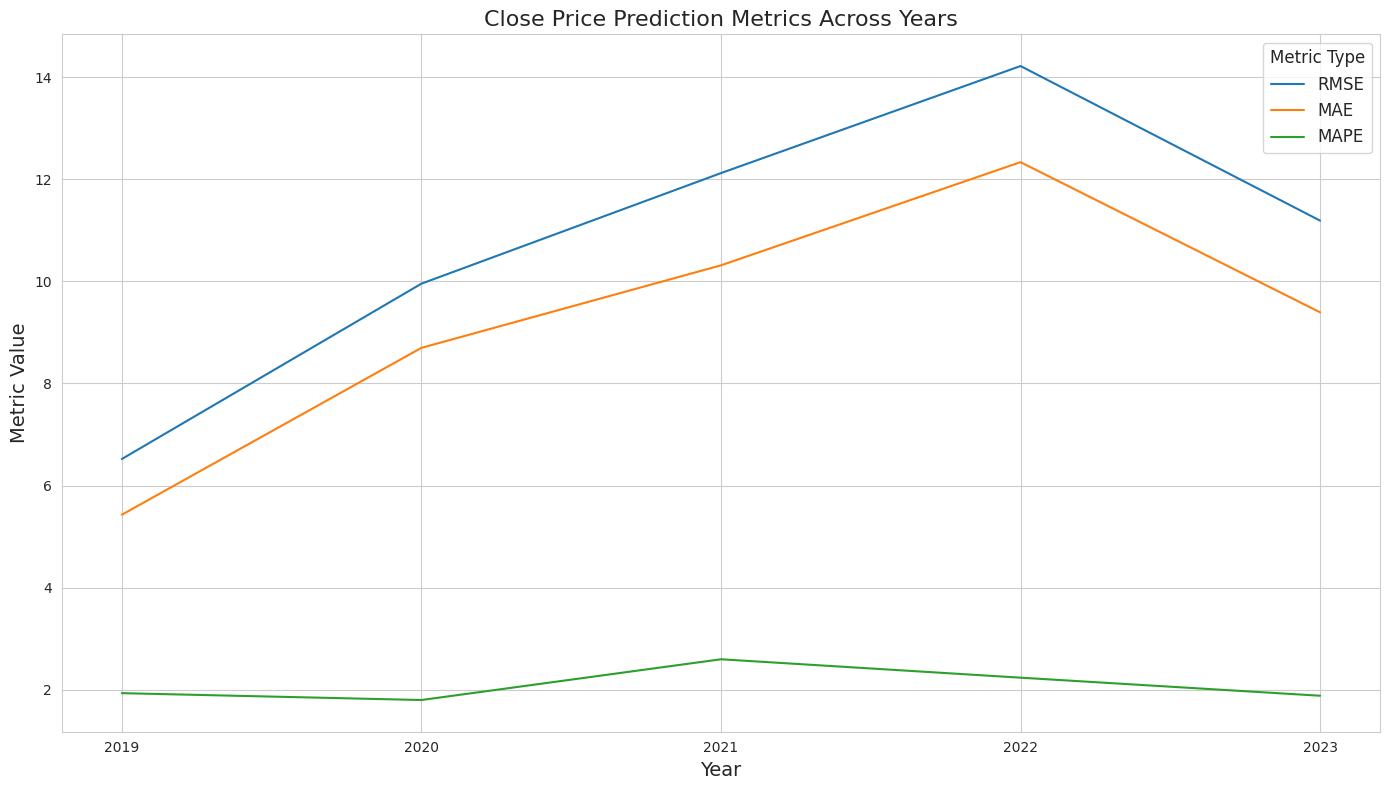

In [56]:
metrics_df = pd.read_csv('validation/aggregated_xgbregressor_all_folds_metrics.csv')

# Calculate average metrics per fold
fold_summary = metrics_df.groupby('Fold').agg({
    'RMSE': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(4)

# Map folds to years
fold_to_year = {1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
fold_summary.index = fold_summary.index.map(fold_to_year)

# Melt the fold_summary for easier plotting with seaborn
fold_summary_reset = fold_summary.reset_index().rename(columns={'Fold': 'Year'})
fold_melted = pd.melt(fold_summary_reset, 
                      id_vars='Year', 
                      var_name='Metric', 
                      value_name='Value')

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a line plot
sns.lineplot(data=fold_melted, 
             x='Year', 
             y='Value', 
             hue='Metric')

# Add titles and labels
plt.title('Close Price Prediction Metrics Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(title='Metric Type', fontsize=12, title_fontsize=12)
plt.xticks(fold_summary_reset['Year'])

# Save the plot
plt.tight_layout()
plt.show()

The graph illustrates the performance of the model across multiple folds, measured by metrics (RMSE, MAE, and MAPE). Analyzing the trends, the following observations can be made:

**Performance Deterioration in 2020, 2021, and 2022**:
- The metrics show a marked increase in these years, indicating a higher prediction error. This suggests that the model struggled to accurately forecast during these periods.
- The observed difficulties in prediction can be attributed to the higher volatility in financial markets caused by significant global events:
    - COVID-19 Pandemic: The onset of the pandemic in early 2020 led to unprecedented market disruptions and increased uncertainty, making it challenging for the model to generalize patterns.
    - Russia-Ukraine War: Geopolitical tensions in 2021 and 2022 likely introduced further volatility, affecting market behavior in unpredictable ways.

**Consistent Trend Across Models**:
- This pattern of struggling performance during volatile periods is consistent across all models tested subsequently, regardless of whether the approach was aggregated or dedicated.
- This indicates that the underlying difficulty lies in the nature of the data during these periods, rather than the specific model or algorithm used.

### 5.2. XGBoost: Dedicated Approach <a name="xgbr_dedicated"></a>
[[go back to the top]](#contents)

In [ ]:
# Run Dedicated XGBoost
run_experiment(xgb.XGBRegressor, 'dedicated', df, feature_cols, folds)

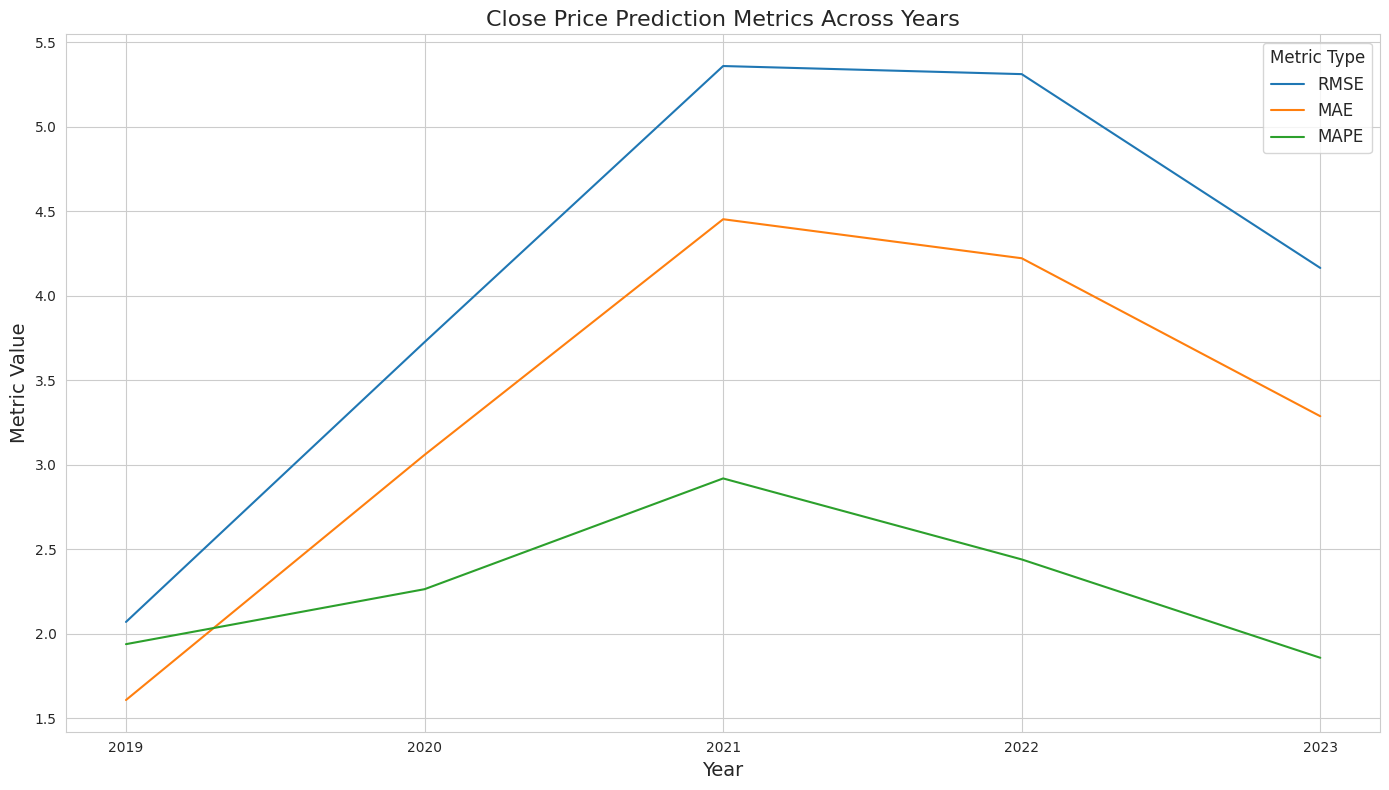

In [57]:
metrics_df = pd.read_csv('validation/dedicated_xgbregressor_all_folds_metrics.csv')

# Calculate average metrics per fold
fold_summary = metrics_df.groupby('Fold').agg({
    'RMSE': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(4)

# Map folds to years
fold_to_year = {1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
fold_summary.index = fold_summary.index.map(fold_to_year)

# Melt the fold_summary for easier plotting with seaborn
fold_summary_reset = fold_summary.reset_index().rename(columns={'Fold': 'Year'})
fold_melted = pd.melt(fold_summary_reset, 
                      id_vars='Year', 
                      var_name='Metric', 
                      value_name='Value')

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a line plot
sns.lineplot(data=fold_melted, 
             x='Year', 
             y='Value', 
             hue='Metric')

# Add titles and labels
plt.title('Close Price Prediction Metrics Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(title='Metric Type', fontsize=12, title_fontsize=12)
plt.xticks(fold_summary_reset['Year'])

# Save the plot
plt.tight_layout()
plt.show()

### 5.3. Random Forest: Aggregated Approach <a name="rf_aggregated"></a>
[[go back to the top]](#contents)

In [ ]:
# Run Aggregated RandomForest
run_experiment(RandomForestRegressor, 'aggregated', df, feature_cols, folds)

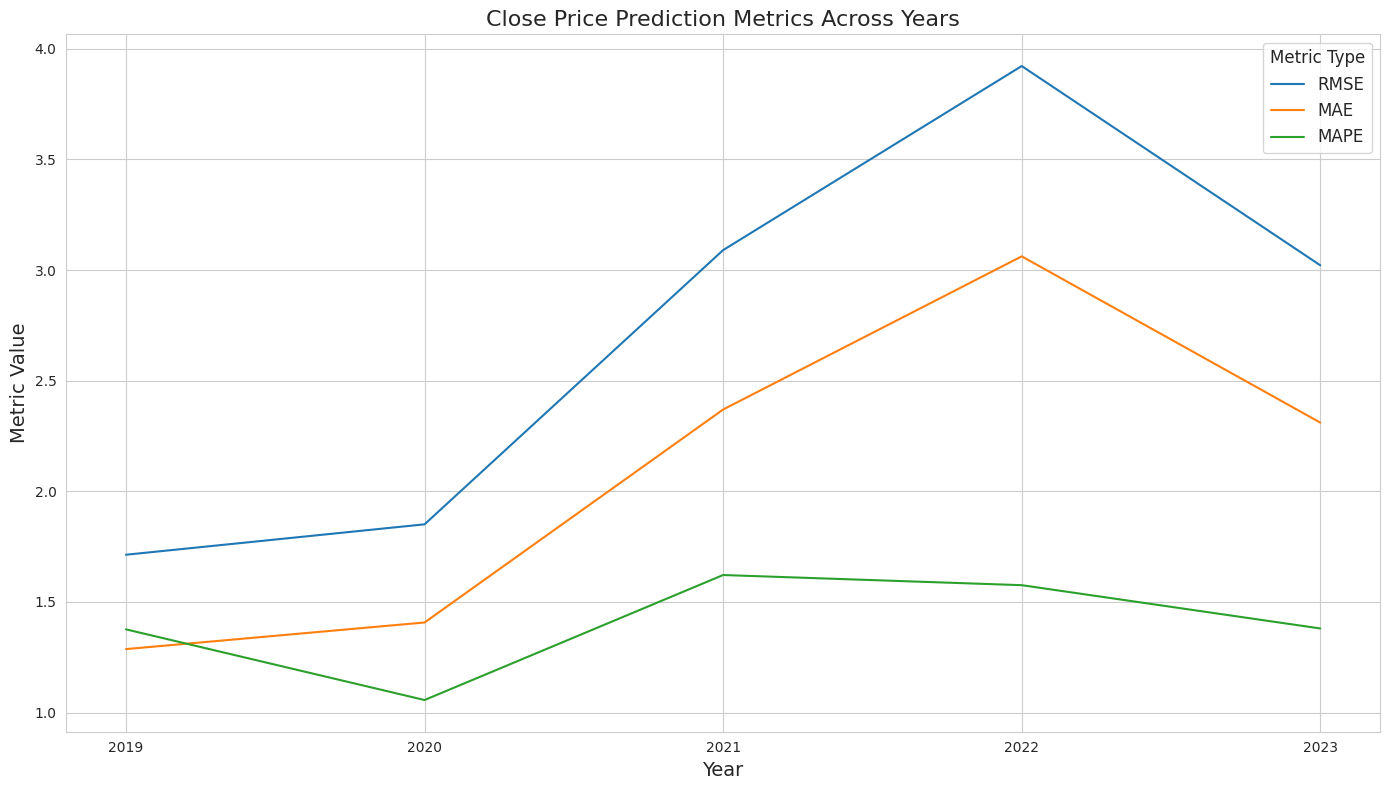

In [58]:
metrics_df = pd.read_csv('validation/aggregated_randomforestregressor_all_folds_metrics.csv')

# Calculate average metrics per fold
fold_summary = metrics_df.groupby('Fold').agg({
    'RMSE': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(4)

# Map folds to years
fold_to_year = {1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
fold_summary.index = fold_summary.index.map(fold_to_year)

# Melt the fold_summary for easier plotting with seaborn
fold_summary_reset = fold_summary.reset_index().rename(columns={'Fold': 'Year'})
fold_melted = pd.melt(fold_summary_reset, 
                      id_vars='Year', 
                      var_name='Metric', 
                      value_name='Value')

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a line plot
sns.lineplot(data=fold_melted, 
             x='Year', 
             y='Value', 
             hue='Metric')

# Add titles and labels
plt.title('Close Price Prediction Metrics Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(title='Metric Type', fontsize=12, title_fontsize=12)
plt.xticks(fold_summary_reset['Year'])

# Save the plot
plt.tight_layout()
plt.show()

### 5.4. Random Forest: Dedicated Approach <a name="rf_dedicated"></a>
[[go back to the top]](#contents)

In [ ]:
# Run Dedicated RandomForest
run_experiment(RandomForestRegressor, 'dedicated', df, feature_cols, folds)

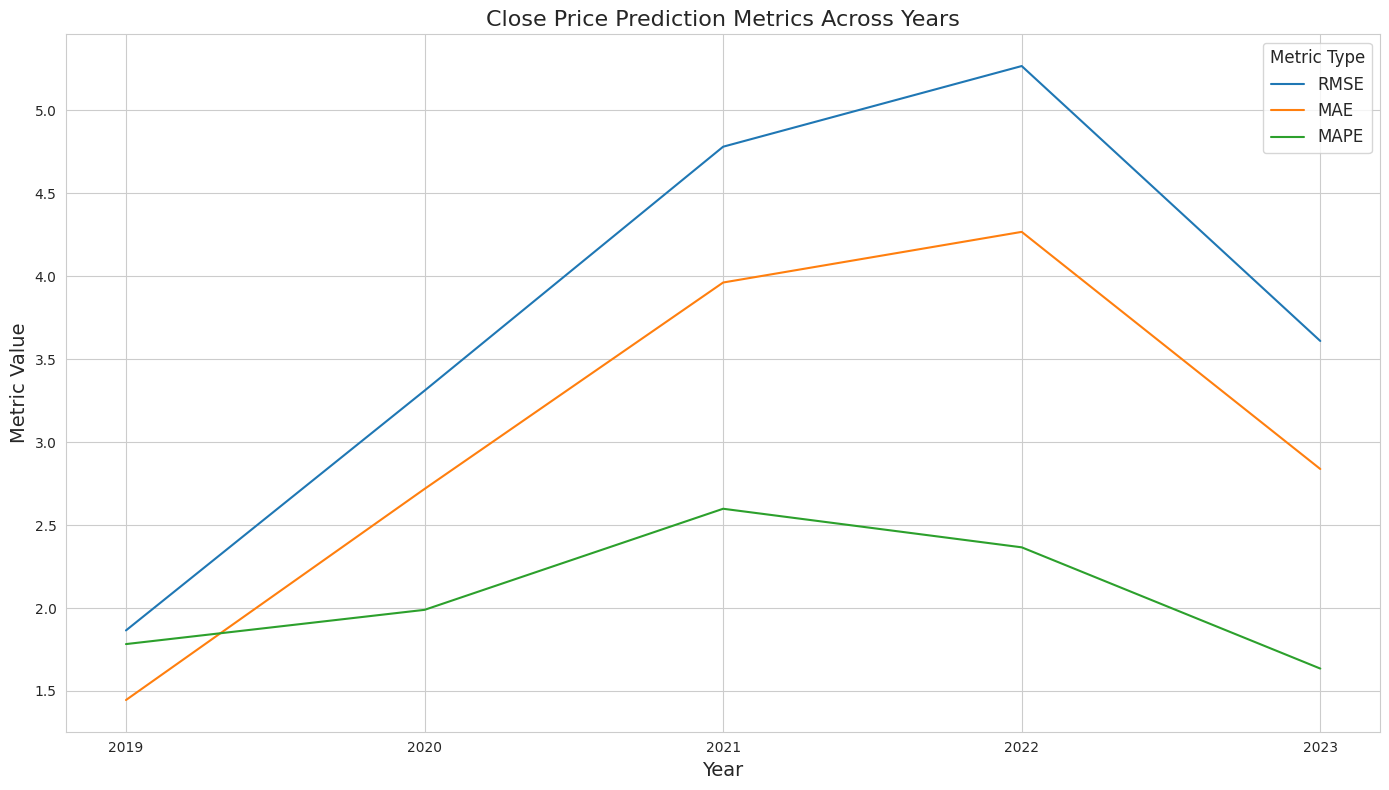

In [59]:
metrics_df = pd.read_csv('validation/dedicated_randomforestregressor_all_folds_metrics.csv')

# Calculate average metrics per fold
fold_summary = metrics_df.groupby('Fold').agg({
    'RMSE': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(4)

# Map folds to years
fold_to_year = {1: 2019, 2: 2020, 3: 2021, 4: 2022, 5: 2023}
fold_summary.index = fold_summary.index.map(fold_to_year)

# Melt the fold_summary for easier plotting with seaborn
fold_summary_reset = fold_summary.reset_index().rename(columns={'Fold': 'Year'})
fold_melted = pd.melt(fold_summary_reset, 
                      id_vars='Year', 
                      var_name='Metric', 
                      value_name='Value')

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a line plot
sns.lineplot(data=fold_melted, 
             x='Year', 
             y='Value', 
             hue='Metric')

# Add titles and labels
plt.title('Close Price Prediction Metrics Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(title='Metric Type', fontsize=12, title_fontsize=12)
plt.xticks(fold_summary_reset['Year'])

# Save the plot
plt.tight_layout()
plt.show()

### 5.5. Model Selection <a name="model_selection"></a>
[[go back to the top]](#contents)

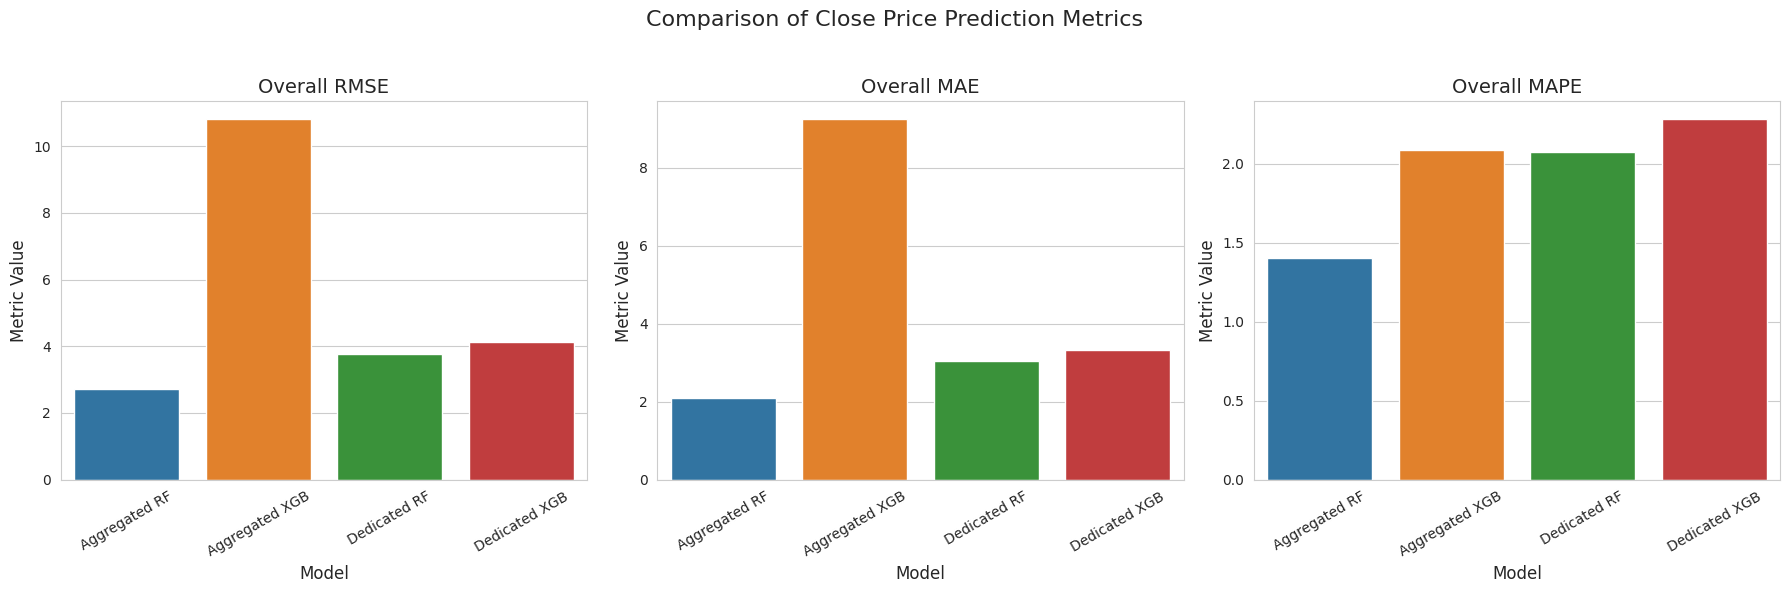


Overall Average Metrics by Model:

Aggregated RF:
MAE: 2.0872
MAPE: 1.4021
RMSE: 2.7195

Aggregated XGB:
MAE: 9.2347
MAPE: 2.0876
RMSE: 10.8023

Dedicated RF:
MAE: 3.0461
MAPE: 2.0741
RMSE: 3.7665

Dedicated XGB:
MAE: 3.3248
MAPE: 2.2829
RMSE: 4.1254


In [35]:
model_files = {
    'Dedicated RF': 'validation/dedicated_randomforestregressor_all_folds_metrics.csv',
    'Aggregated RF': 'validation/aggregated_randomforestregressor_all_folds_metrics.csv',
    'Dedicated XGB': 'validation/dedicated_xgbregressor_all_folds_metrics.csv',
    'Aggregated XGB': 'validation/aggregated_xgbregressor_all_folds_metrics.csv',
}

metrics_summaries = {}

# Process each model's metrics
for model_name, file_path in model_files.items():
    # Load metrics
    metrics_df = pd.read_csv(file_path)
    
    # Calculate average metrics per fold
    fold_summary = metrics_df.groupby('Fold').agg({
        'RMSE': 'mean',
        'MAE': 'mean',
        'MAPE': 'mean'
    }).round(4)
    
    fold_summary['Model'] = model_name  # Add model name for identification
    metrics_summaries[model_name] = fold_summary

# Combine all fold summaries into a single DataFrame
combined_fold_summary = pd.concat(metrics_summaries.values()).reset_index()

# Melt the DataFrame for plotting
fold_melted = pd.melt(
    combined_fold_summary,
    id_vars=['Fold', 'Model'],
    var_name='Metric',
    value_name='Value'
)

# Calculate overall averages for each model and metric
overall_averages = fold_melted.groupby(['Model', 'Metric']).agg({'Value': 'mean'}).reset_index()

# Plot metrics in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
sns.set_style("whitegrid")

for idx, metric in enumerate(['RMSE', 'MAE', 'MAPE']):
    metric_data = overall_averages[overall_averages['Metric'] == metric]
    sns.barplot(ax=axes[idx], data=metric_data, x='Model', y='Value', hue='Model', dodge=False)
    axes[idx].set_title(f'Overall {metric}', fontsize=14)
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel('Metric Value', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=30)

fig.suptitle('Comparison of Close Price Prediction Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print numerical results
print("\nOverall Average Metrics by Model:")
for model in overall_averages['Model'].unique():
    print(f"\n{model}:")
    model_metrics = overall_averages[overall_averages['Model'] == model]
    for _, row in model_metrics.iterrows():
        print(f"{row['Metric']}: {row['Value']:.4f}")

Based on the results from the 5 validation periods, **Aggregated RF** appears to consistently have **lower metric values** (RMSE, MAE, and MAPE) compared to the other models. Lower values for these metrics indicate better performance, so this seems a good candidate to train on the full data.

## 6. Evaluation <a name="evaluation"></a>
[[go back to the top]](#contents)

Based on the validation results across **five different January periods (2019-2023)**, the Aggregated Random Forest approach consistently demonstrated superior performance with lower error metrics (RMSE: 2.72, MAE: 2.09, MAPE: 1.40%) compared to other models. This robust performance led to our decision to implement the Aggregated Random Forest strategy, training a single model on the complete historical dataset from **2010 to 2023** to predict stock prices for **January 2024**.

In [ ]:
def evaluate_model(full_data, feature_cols, model_class):
    """
    Train model on data up to end of 2023 and predict January 2024.
    """
    # Split data into train and test
    train_end_date = '2023-12-31'
    eval_start_date = '2024-01-01'
    eval_end_date = '2024-01-31'
    
    # Convert dates to timestamps
    train_end_date = pd.Timestamp(train_end_date)
    eval_start_date = pd.Timestamp(eval_start_date)
    eval_end_date = pd.Timestamp(eval_end_date)
    
    # Prepare training data
    train_data = full_data[full_data['Date'] <= train_end_date].copy()
    train_data = train_data.dropna(subset=['Next_Close'])
    
    # Prepare features and target
    X_train = train_data[feature_cols]
    y_train = train_data['Next_Close']
    
    # Train model
    print(f"Training model up to {train_end_date.date()}...")
    model = model_class(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("Model trained successfully.")
    
    # Save the trained model
    os.makedirs('test', exist_ok=True)
    joblib.dump(model, 'test/saved_model.pkl')
    
    # Make predictions for January 2024
    all_predictions = []
    symbols = full_data['Symbol'].unique()
    total_symbols = len(symbols)
    
    for idx, symbol in enumerate(symbols, 1):
        print(f"\nProcessing predictions for {symbol} ({idx}/{total_symbols})")
        symbol_data = full_data[full_data['Symbol'] == symbol].sort_values('Date')
        
        # Get the last day of 2023 for this symbol
        last_2023_data = symbol_data[symbol_data['Date'] <= train_end_date].iloc[-1:]
        
        # Get January 2024 dates for this symbol
        jan_2024_data = symbol_data[
            (symbol_data['Date'] >= eval_start_date) & 
            (symbol_data['Date'] <= eval_end_date)
        ]
        
        # Combine last 2023 day with January 2024 data
        prediction_data = pd.concat([last_2023_data, jan_2024_data])
        prediction_data = prediction_data.sort_values('Date')
        
        symbol_predictions = []
        for i in range(len(prediction_data) - 1):  
            current_row = prediction_data.iloc[i]
            next_row = prediction_data.iloc[i + 1]
            
            # Skip if we have missing data
            if current_row[feature_cols].isnull().any():
                continue
                
            # Make prediction
            X_pred = current_row[feature_cols].to_frame().T
            pred_close = model.predict(X_pred)[0]
            
            symbol_predictions.append({
                'Date': next_row['Date'],
                'Symbol': symbol,
                'Predicted_Close': pred_close,
                'Actual_Close': next_row['Close']
            })
            
        all_predictions.extend(symbol_predictions)
        
    return pd.DataFrame(all_predictions), model_class.__name__

def compute_metrics(predictions_df):
    """Compute metrics for all stocks"""
    metrics_list = []
    
    for symbol in predictions_df['Symbol'].unique():
        sym_data = predictions_df[predictions_df['Symbol'] == symbol]
        
        mask = sym_data['Actual_Close'].notnull() & sym_data['Predicted_Close'].notnull()
        actual = sym_data.loc[mask, 'Actual_Close']
        pred = sym_data.loc[mask, 'Predicted_Close']
        
        if len(actual) > 0:
            metrics_list.append({
                'Symbol': symbol,
                'RMSE': np.sqrt(((actual - pred)**2).mean()),
                'MAE': np.abs(actual - pred).mean(),
                'MAPE': np.abs((actual - pred) / actual).mean() * 100
            })
    
    return pd.DataFrame(metrics_list)

# Main execution
print("Loading data...")
df = pd.read_csv('data/processed_full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Create next day target if not present
if 'Next_Close' not in df.columns:
    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)

# Define features
feature_cols = [
    'Open', 'Close', 'High', 'Low', 'Volume', 
    'SMA_10', 'SMA_20', 'EMA_10', 'MACD', 'RSI', 
    'BB_Width', 'Daily_Return', '5d_Return', 'Volume_RSI',
    'Sector_Mean_Daily_Return', 'Sector_Min_Daily_Return',
    'Sector_Max_Daily_Return', 'Sector_Std_Daily_Return',
    'Sector_Mean_5d_Return', 'Sector_Min_5d_Return',
    'Sector_Max_5d_Return', 'Sector_Std_5d_Return'
]

os.makedirs('test', exist_ok=True)

# Train and save the model
predictions, model_name = evaluate_model(df, feature_cols, RandomForestRegressor)

# Compute and save metrics
test_metrics = compute_metrics(predictions)

# Save results
predictions.to_csv('test/predictions_january_2024.csv', index=False)
test_metrics.to_csv('test/metrics_january_2024.csv', index=False)

We also proceeded to analyse the **model's interpretability**, using the random forest feature importance.

We noticed the model's predictions for next-day closing prices are primarily driven by recent price action, with the previous **closing price** being the **dominant feature**. 

The hierarchy of feature importance follows a clear and intuitive pattern: closing price leads, followed by low price and high price, which together define the day's trading range. Technical indicators and sector-related features show minimal influence, suggesting that the fundamental price action contains most of the predictive information.

This feature importance distribution makes the model highly explainable - it's making predictions primarily based on the most recent market consensus (closing price) and the day's trading range, rather than relying on complex technical patterns or sector behaviors.

In [46]:
# Read the metrics file
metrics = pd.read_csv('test/metrics_january_2024.csv')

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average RMSE: {metrics['RMSE'].mean():.2f}")
print(f"Average MAE: {metrics['MAE'].mean():.2f}")
print(f"Average MAPE: {metrics['MAPE'].mean():.2f}")


Summary Statistics:
Average RMSE: 3.00
Average MAE: 2.26
Average MAPE: 1.08


The model, when trained on the complete dataset (2010-2023) and tested on **January 2024**, delivered a solid performance with an RMSE of 3.00, MAE of 2.26, and MAPE of 1.08%. These results are consistent with, and even slightly better than, the validation tests (particularly the MAPE which improved from 1.40% overall to 1.08%). This suggests that using the full historical dataset for training has indeed benefited the model's predictive capabilities. The low MAPE of 1.08% indicates that, on average, our predictions **deviate** only **about 1%** from the actual closing prices.

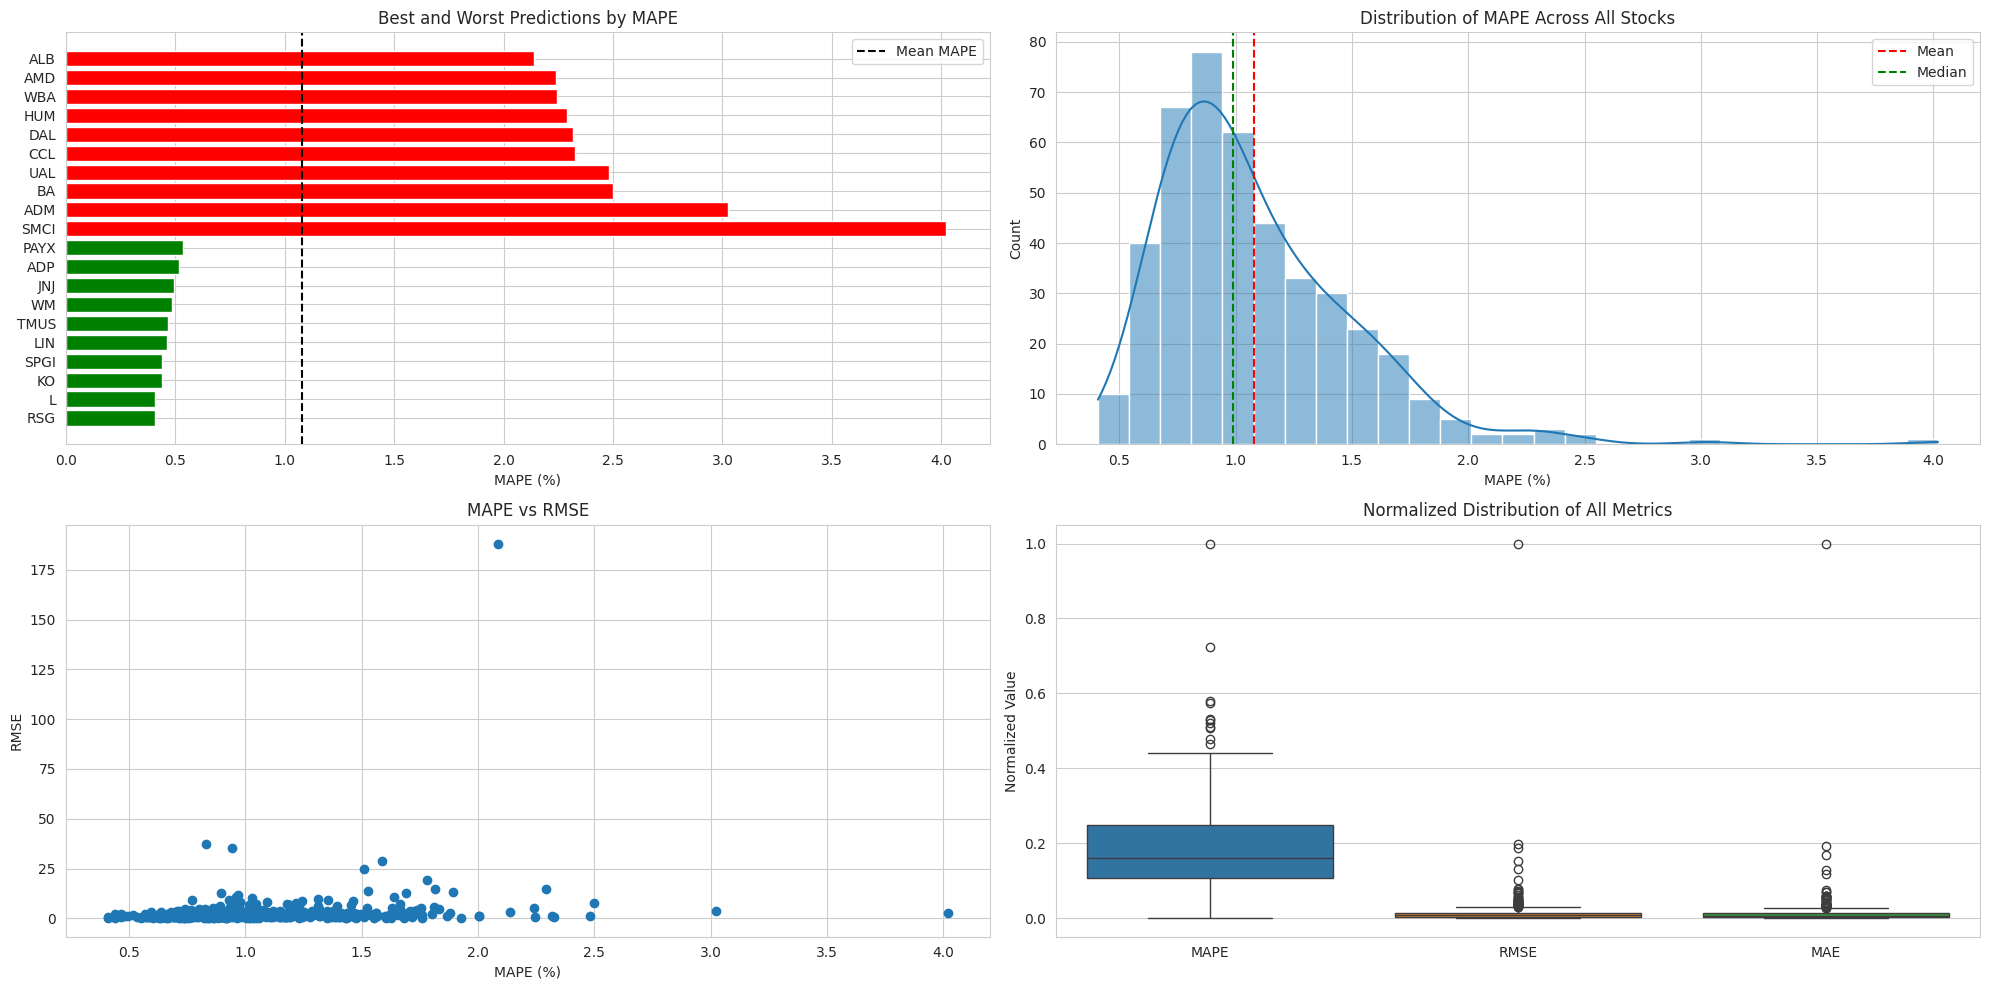

In [43]:
metrics = pd.read_csv('test/metrics_january_2024.csv')

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 10))

# 1. Top and Bottom 10 Stocks by MAPE
plt.subplot(2, 2, 1)
top_10 = metrics.nsmallest(10, 'MAPE')
bottom_10 = metrics.nlargest(10, 'MAPE')
combined = pd.concat([top_10, bottom_10])
combined['Color'] = ['green']*10 + ['red']*10
plt.barh(y=combined['Symbol'], width=combined['MAPE'], color=combined['Color'])
plt.title('Best and Worst Predictions by MAPE')
plt.xlabel('MAPE (%)')
plt.axvline(metrics['MAPE'].mean(), color='black', linestyle='--', label='Mean MAPE')
plt.legend()

# 2. Distribution of MAPE
plt.subplot(2, 2, 2)
sns.histplot(data=metrics, x='MAPE', kde=True)
plt.axvline(metrics['MAPE'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(metrics['MAPE'].median(), color='green', linestyle='--', label='Median')
plt.title('Distribution of MAPE Across All Stocks')
plt.xlabel('MAPE (%)')
plt.ylabel('Count')
plt.legend()

# 3. MAPE vs RMSE scatter
plt.subplot(2, 2, 3)
plt.scatter(metrics['MAPE'], metrics['RMSE'])
plt.title('MAPE vs RMSE')
plt.xlabel('MAPE (%)')
plt.ylabel('RMSE')

# 4. Box plot of all metrics (normalized)
plt.subplot(2, 2, 4)
metrics_normalized = metrics[['MAPE', 'RMSE', 'MAE']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
sns.boxplot(data=metrics_normalized)
plt.title('Normalized Distribution of All Metrics')
plt.ylabel('Normalized Value')

plt.tight_layout()
plt.show()

**Best/Worst Predictions (Top Left)**:
- Best performing stocks (green) have MAPE around 0.5% or lower, with RSG being the best
- Worst performing stocks (red) have MAPE between 2-4%, with SMCI showing notably high error
- The mean MAPE (dotted line) suggests generally good predictions across stocks

**MAPE Distribution (Top Right)**:
- Most stocks cluster around 0.8-1.2% MAPE
- Very few stocks have MAPE above 2%
- Peak of the distribution is around 0.9-1.0%

**MAPE vs RMSE (Bottom Left)**:
- Strong positive correlation between MAPE and RMSE
- One significant outlier with RMSE around 175
- Most stocks cluster in the lower left, indicating consistent predictions

**Normalized Metrics (Bottom Right)**:
- All three metrics show similar patterns when normalized
- Several outliers in all metrics

Overall, these visualizations suggest the model performs **consistently well** across most stocks, with only a few outliers showing higher prediction errors.


Performance by Sector:
                          RMSE     MAE    MAPE
Sector                                        
Communication Services  1.6274  1.1954  1.1019
Consumer Discretionary  8.2168  6.3663  1.1326
Consumer Staples        1.3840  1.0302  1.0093
Energy                  1.4779  1.1535  1.2254
Financials              1.9414  1.4471  0.9460
Health Care             3.8482  2.8514  1.1145
Industrials             2.7364  1.9673  0.9886
Information Technology  3.8326  2.8994  1.3474
Materials               1.9040  1.4497  1.0691
Real Estate             1.8002  1.3982  1.0820
Utilities               0.7175  0.5398  0.9135


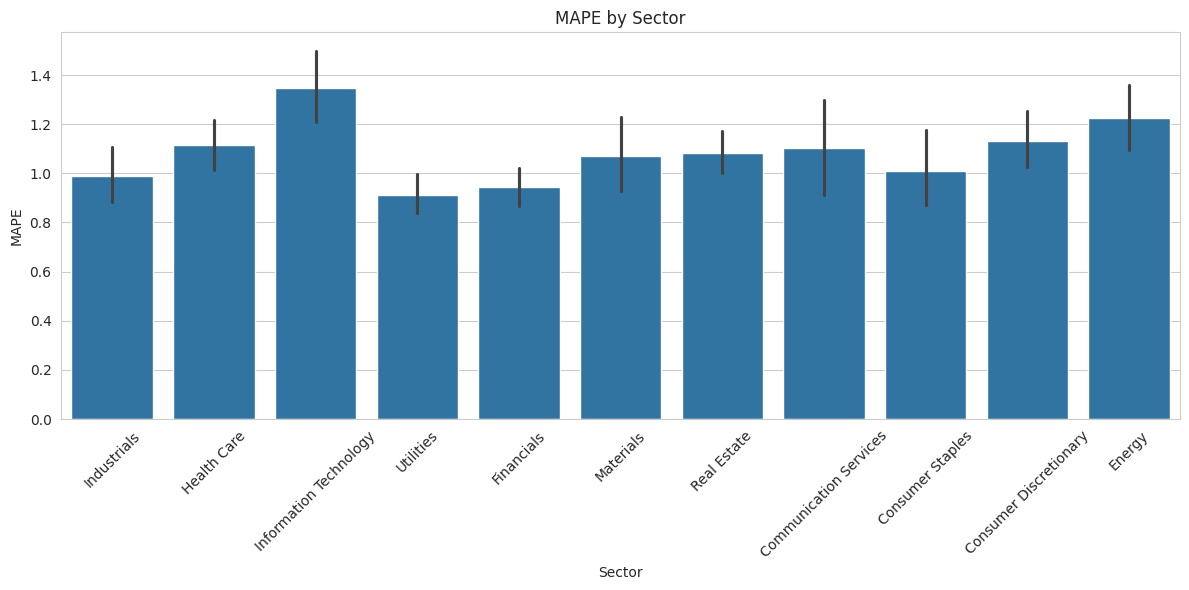

In [39]:
# Merge with sector information
df_with_sectors = metrics.merge(
    df[['Symbol', 'Sector']].drop_duplicates(),
    on='Symbol'
)

# Calculate average metrics by sector
sector_performance = df_with_sectors.groupby('Sector').agg({
    'RMSE': 'mean',
    'MAE': 'mean',
    'MAPE': 'mean'
}).round(4)

print("\nPerformance by Sector:")
print(sector_performance)

# Visualize sector performance
plt.figure(figsize=(12, 6))
sns.barplot(data=df_with_sectors, x='Sector', y='MAPE')
plt.xticks(rotation=45)
plt.title('MAPE by Sector')
plt.tight_layout()
plt.show()

When analysing the performance by sector we observe that:

- Traditional, stable sectors (Utilities, Industrials) are more predictable
- Tech and cyclical sectors (IT, Consumer Discretionary) show higher prediction errors
- Energy sector's higher MAPE might reflect its inherent volatility
- All sectors maintain MAPE below 1.5%, suggesting robust model performance 

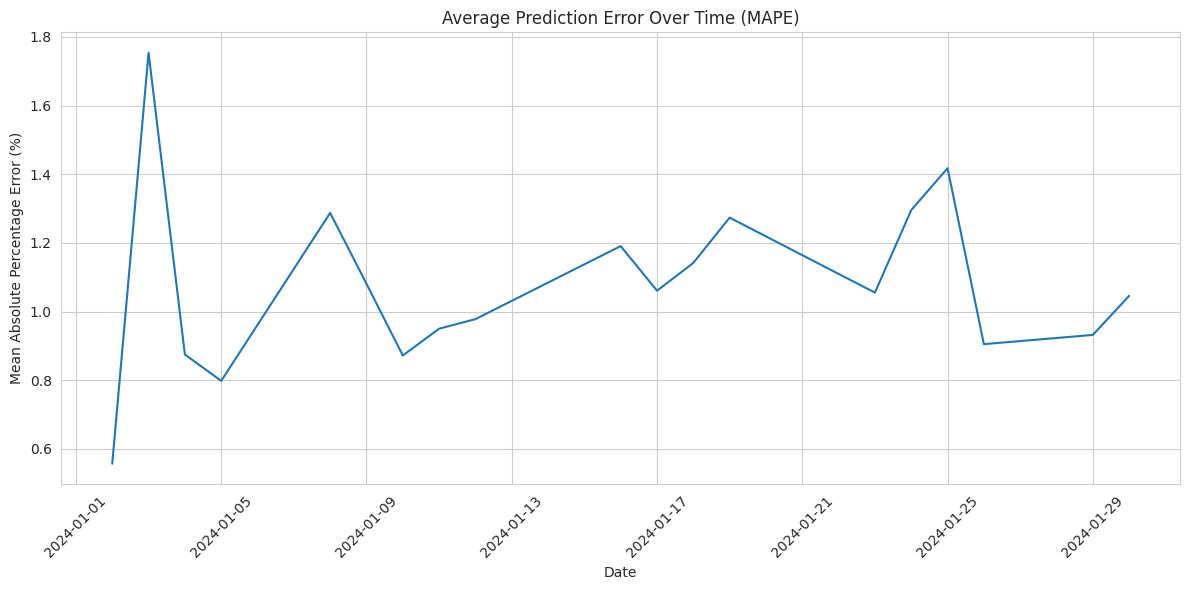


Prediction Error by Weekday (MAPE):
               MAPE  Count
Weekday                   
Monday     1.109627   1290
Tuesday    0.985907   2150
Wednesday  1.245497   1720
Thursday   1.096044   1720
Friday     0.988674   1720


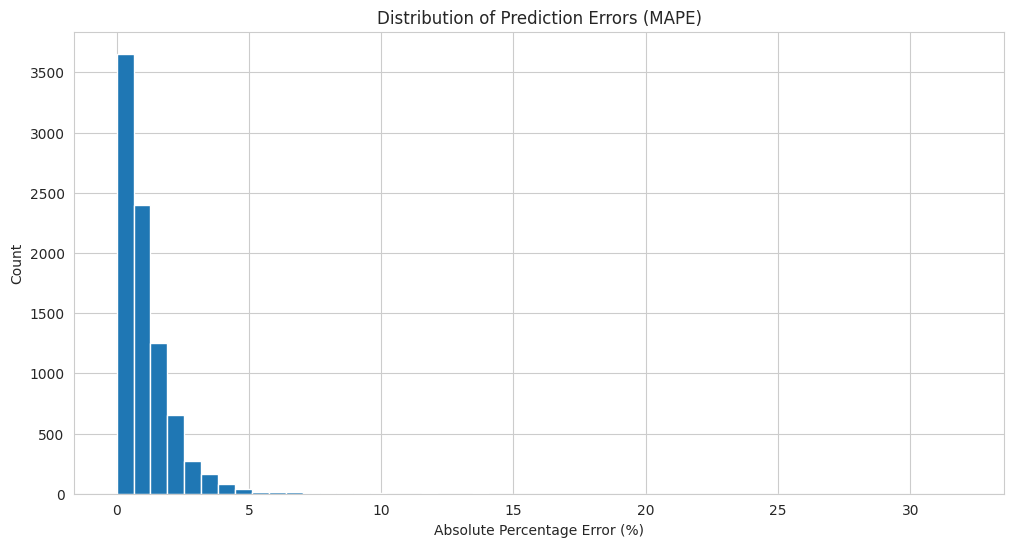

In [49]:
# Load the saved files
predictions = pd.read_csv('test/predictions_january_2024.csv')
metrics = pd.read_csv('test/metrics_january_2024.csv')
predictions['Date'] = pd.to_datetime(predictions['Date'])

# Calculate daily percentage errors
daily_error = predictions.groupby('Date', as_index=False).agg(
    Mean_Percentage_Error=('Predicted_Close', lambda x: (np.abs(x - predictions.loc[x.index, 'Actual_Close']) / predictions.loc[x.index, 'Actual_Close'] * 100).mean())
)

plt.figure(figsize=(12, 6))
plt.plot(daily_error['Date'], daily_error['Mean_Percentage_Error'])
plt.title('Average Prediction Error Over Time (MAPE)')
plt.xlabel('Date')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Create Weekday column and analyze
predictions['Weekday'] = pd.to_datetime(predictions['Date']).dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Weekday Analysis with MAPE
weekday_stats = predictions.groupby('Weekday').agg(
    MAPE=('Predicted_Close', lambda x: (np.abs(x - predictions.loc[x.index, 'Actual_Close']) / predictions.loc[x.index, 'Actual_Close'] * 100).mean()),
    Count=('Predicted_Close', 'count')
)
weekday_stats = weekday_stats.reindex(weekday_order)

print("\nPrediction Error by Weekday (MAPE):")
print(weekday_stats)

These results suggest the model is performing consistently well, with most predictions falling within a reasonable error range of less than 2%, though there are occasional periods of higher uncertainty.

## 7. Optimization <a name="optimization"></a>
[[go back to the top]](#contents)

Before implementing portfolio optimization strategies, we need to prepare and organize our dataset. This code processes **historical stock data** and combines it with **price predictions** to create a comprehensive dataset for optimization. The resulting dataset contains all necessary information for **portfolio optimization**: historical prices, returns, volatility measures, and expected future returns based on predictions.

In [4]:
# Load the base data
print("Loading and preparing base data...")
df = pd.read_csv('data/processed_full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Volatility'] = df.groupby("Symbol")["Daily_Return"].rolling(window=5).std().reset_index(level=0, drop=True)

# Select base data columns
columns_to_keep = ['Date', 'Symbol', 'Close', 'Daily_Return', 'Volatility']
df_filtered = df[columns_to_keep]

# Filter for 2024 AND last day of 2023
df_filtered = df_filtered[
    (df_filtered['Date'].dt.year == 2024) | 
    ((df_filtered['Date'].dt.year == 2023) & (df_filtered['Date'].dt.month == 12) & (df_filtered['Date'].dt.day == 29))
]

# Load predictions data
print("Loading predictions data...")
predictions = pd.read_csv('predictions_january_2024.csv')
predictions['Date'] = pd.to_datetime(predictions['Date'])

# Merge the datasets
print("Merging datasets...")
df_merged = df_filtered.merge(predictions[['Date', 'Symbol', 'Predicted_Close']], 
                            on=['Date', 'Symbol'], 
                            how='left')

# Calculate Expected_Return
print("Calculating Expected Return...")
df_merged['Previous_Close'] = df_merged.groupby('Symbol')['Close'].shift(1)
df_merged['Expected_Return'] = (df_merged['Predicted_Close'] - df_merged['Previous_Close']) / df_merged['Previous_Close']

# Now filter for 2024 after calculating Expected_Return
df_final = df_merged[df_merged['Date'].dt.year == 2024]

# Final columns order
final_columns = ['Date', 'Symbol', 'Close', 'Predicted_Close', 
                'Daily_Return', 'Expected_Return', 'Volatility']
df_final = df_final[final_columns]

# Save to new CSV
print("Saving final dataset...")
df_final.to_csv('optimization_data.csv', index=False)

# Print info about the final dataset
print("\nFinal Dataset Info:")
print(f"Number of rows: {len(df_final)}")
print(f"Number of stocks: {df_final['Symbol'].nunique()}")
print(f"Date range: {df_final['Date'].min()} to {df_final['Date'].max()}")

# Show the first few rows to verify structure
print("\nFirst few rows of final dataset:")
print(df_final.head())

# Verify Expected_Return calculation for first day
print("\nFirst day Expected Returns verification:")
first_day = df_final[df_final['Date'] == df_final['Date'].min()]
print(first_day[['Date', 'Symbol', 'Predicted_Close', 'Expected_Return']].head())

Loading and preparing base data...
Loading predictions data...
Merging datasets...
Calculating Expected Return...
Saving final dataset...

Final Dataset Info:
Number of rows: 8600
Number of stocks: 430
Date range: 2024-01-02 00:00:00 to 2024-01-30 00:00:00

First few rows of final dataset:
        Date Symbol      Close  Predicted_Close  Daily_Return  \
1 2024-01-02    MMM  88.892036        88.647387      0.006220   
2 2024-01-03    MMM  87.106117        88.803878     -0.020091   
3 2024-01-04    MMM  87.413200        87.359636      0.003525   
4 2024-01-05    MMM  87.752602        87.856376      0.003883   
5 2024-01-08    MMM  87.970787        87.850858      0.002486   

   Expected_Return  Volatility  
1         0.003451    0.007200  
2        -0.000992    0.011859  
3         0.002910    0.011592  
4         0.005070    0.010746  
5         0.001120    0.010873  

First day Expected Returns verification:
         Date Symbol  Predicted_Close  Expected_Return
1  2024-01-02    MMM   

To implement effective portfolio optimization, a crucial step is calculating the **covariance matrix** for the stocks in our investment universe. This matrix captures the relationships between different stocks' returns, helping us understand how **they move together** or **in opposite directions**. By analyzing historical daily returns over a rolling 60-day window, we compute covariance matrices for **each trading day in January 2024**. These matrices are essential inputs for **modern portfolio theory techniques**, allowing us to balance expected returns against risk when constructing optimal portfolios.

In [5]:
print("Loading data...")
# Load the full dataset
df = pd.read_csv('data/processed_full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Get January 2024 dates
january_dates = df[df['Date'].dt.year == 2024]['Date'].unique()

print(f"Calculating covariance matrices for {len(january_dates)} days in January 2024...")

# Create pivot table using the Daily_Return that's already calculated in the dataset
returns_pivot = df.pivot_table(index='Date', columns='Symbol', values='Daily_Return')

# Dictionary to store covariance matrices
covariance_matrices = {}

for date in january_dates:
    # Get end date for the window (day before current date)
    end_date = date - pd.Timedelta(days=1)
    # Get start date 
    start_date = end_date - pd.Timedelta(days=60)
    
    # Get data for this window
    window_data = returns_pivot[(returns_pivot.index > start_date) & 
                               (returns_pivot.index <= end_date)]
    
    # Calculate covariance matrix for this window
    cov_matrix = window_data.cov()
    
    # Store the matrix
    covariance_matrices[date] = cov_matrix
    
    print(f"Calculated covariance matrix for {date.strftime('%Y-%m-%d')}")

# Save each matrix to a separate file
print("\nSaving covariance matrices...")
for date, matrix in covariance_matrices.items():
    filename = f'data/covariance_matrix_{date.strftime("%Y%m%d")}.csv'
    matrix.to_csv(filename)
    
# Print validation information
first_date = min(covariance_matrices.keys())
first_matrix = covariance_matrices[first_date]

print("\nValidation Info:")
print(f"Number of covariance matrices: {len(covariance_matrices)}")
print(f"Matrix dimensions: {first_matrix.shape}")
print(f"Number of stocks in first matrix: {len(first_matrix.columns)}")
print(f"\nSample dates covered for first matrix ({first_date.strftime('%Y-%m-%d')}):")
window_data = returns_pivot[(returns_pivot.index > (first_date - pd.Timedelta(days=60))) & 
                           (returns_pivot.index <= (first_date - pd.Timedelta(days=1)))]
print(f"Start: {window_data.index.min().strftime('%Y-%m-%d')}")
print(f"End: {window_data.index.max().strftime('%Y-%m-%d')}")
print(f"Number of days in window: {len(window_data)}")

# Verify there are no NaN values
print("\nNaN Check:")
for date, matrix in covariance_matrices.items():
    nan_count = matrix.isna().sum().sum()
    if nan_count > 0:
        print(f"Warning: {nan_count} NaN values found in matrix for {date.strftime('%Y-%m-%d')}")

Loading data...
Calculating covariance matrices for 20 days in January 2024...
Calculated covariance matrix for 2024-01-02
Calculated covariance matrix for 2024-01-03
Calculated covariance matrix for 2024-01-04
Calculated covariance matrix for 2024-01-05
Calculated covariance matrix for 2024-01-08
Calculated covariance matrix for 2024-01-09
Calculated covariance matrix for 2024-01-10
Calculated covariance matrix for 2024-01-11
Calculated covariance matrix for 2024-01-12
Calculated covariance matrix for 2024-01-16
Calculated covariance matrix for 2024-01-17
Calculated covariance matrix for 2024-01-18
Calculated covariance matrix for 2024-01-19
Calculated covariance matrix for 2024-01-22
Calculated covariance matrix for 2024-01-23
Calculated covariance matrix for 2024-01-24
Calculated covariance matrix for 2024-01-25
Calculated covariance matrix for 2024-01-26
Calculated covariance matrix for 2024-01-29
Calculated covariance matrix for 2024-01-30

Saving covariance matrices...

Validatio

Next, we prepared two functions:

The **load_stock_data** function retrieves stock information for a specific date, serving two key purposes:
- Creates a structured list of dictionaries (stocks_data) containing comprehensive information for each stock:
- Creates a simplified dictionary (model_predictions) mapping stock symbols to their expected returns

The **load_covariance_matrix** function loads the pre-calculated covariance matrix for a given date from a CSV file. These matrices, which we calculated earlier, capture the relationships between stock returns and are essential for risk assessment in portfolio optimization.
Together, these functions provide the necessary inputs for portfolio optimization:
- Individual stock metrics from load_stock_data
- Risk relationships between stocks from load_covariance_matrix

In [6]:
def load_stock_data(csv_path, date):
    """
    Load stock data from a CSV file for a specific date.

    Parameters:
    - csv_path (str): Path to the CSV file containing stock data.
    - date (str): The date in 'YYYY-MM-DD' format.

    Returns:
    - stocks_data (list): List of dictionaries containing stock data for the specified date.
    - model_predictions (dict): Predicted returns for each stock on the specified date.
    """
    df = pd.read_csv(csv_path, parse_dates=["Date"])
    filtered_df = df[df["Date"] == date]
    filtered_df = filtered_df.sort_values(by=["Symbol"])
    stock_symbols = filtered_df["Symbol"].unique()
    
    stocks_data = []
    model_predictions = {}

    for symbol in stock_symbols:
        stock_data = filtered_df[filtered_df["Symbol"] == symbol]
        

        stocks_data.append({
            "name": symbol,
            "predicted_price": stock_data["Predicted_Close"].iloc[0],
            "expected_return": stock_data["Expected_Return"].iloc[0],
            "volatility": stock_data["Volatility"].iloc[0],
            "price": stock_data["Close"].iloc[0]
        })

        model_predictions[symbol] = stock_data["Expected_Return"].iloc[0]

    return stocks_data, model_predictions

def load_covariance_matrix(date):
    """
    Load the covariance matrix for the specified date.

    Parameters:
    - date (str): The date in 'YYYY-MM-DD' format.

    Returns:
    - cov_matrix (pd.DataFrame): The covariance matrix as a DataFrame.
    """
    file_path = f"data/covariance_matrix_{date.strftime('%Y%m%d')}.csv"
    cov_matrix = pd.read_csv(file_path, index_col=0)
    return cov_matrix

Then we prepared the **StockMinimaxOptimizer** class, which offers a structured approach to daily portfolio optimization, integrating both a **minimax-based selection process** and **Markowitz optimization principles**. It aims to balance returns against risk while enforcing real-world constraints like budgets and transaction costs, and was inspired by the following references **[6],[7],[8],[9],[10]**.

**Initialization & Core Metrics**:
- Loads comprehensive stock data, including predicted returns and a covariance matrix
- Computes portfolio returns and risk metrics, including Value at Risk (VaR)
- Calculates Sharpe Ratios to evaluate risk-adjusted performance

**Portfolio Selection**:
- Reduces the initial stock universe to a targeted number based on Sharpe Ratio rankings
- Uses a minimax algorithm to explore and compare subsets of stocks, identifying promising combinations
- Limits the portfolio size up to a specified max_subset_size for manageability

**Optimization & Allocation**:
- Runs Markowitz optimization to determine optimal weighting of the selected subset, focusing on VaR minimization
- Enforces constraints like weight normalization and bounded allocations to maintain a stable portfolio

**Budget Management & Transactions**:
- Implements a detailed budget control mechanism, adjusting allocations to fit the available capital
- Incorporates transaction costs and sets a maximum transaction limit to simulate realistic trading conditions
- Dynamically updates holdings, selling off unneeded positions and adjusting to new weight targets

**Execution & Outcome**:
- Selects the best final portfolio configuration based on a combined evaluation of returns and VaR
- Executes the necessary trades, updates the portfolio accordingly, and records the resulting value

Overall, the StockMinimaxOptimizer class provides a full-cycle, **daily optimization framework**. It manages portfolio composition, balances risk and return, and ensures that practical constraints like budget limits, transaction costs, and maximum transactions are respected throughout the investment process.

In [9]:
class StockMinimaxOptimizer:
    def __init__(self, stocks_data, model_predictions, cov_matrix, max_subset_size=10, initial_budget=10000):
        self.stocks_data = stocks_data
        self.model_predictions = model_predictions
        self.max_subset_size = max_subset_size
        self.total_budget = initial_budget
        self.current_portfolio = {}
        self.cov_matrix = cov_matrix
        self.total_value = initial_budget

    def evaluate_portfolio(self, portfolio):
        """
        Evaluate a portfolio by calculating its predicted return.
        :param portfolio: List of stock names.
        :return: Predicted portfolio return.
        """
        returns = np.array([self.model_predictions[stock] for stock in portfolio])
        weights = np.ones(len(portfolio)) / len(portfolio)
        portfolio_return = np.dot(weights, returns)
        return portfolio_return
        
    def evaluate_portfolio_2(self, portfolio, weights):
        """
        Evaluate a portfolio by calculating its predicted return.
        :param portfolio: List of stock names.
        :param weights: List of weights corresponding to the stocks in the portfolio.
        :return: Predicted portfolio return.
        """
        if len(weights) != len(portfolio):
            raise ValueError("Length of weights must match the length of the portfolio.")

        returns = np.array([self.model_predictions[stock] for stock in portfolio])
        portfolio_return = np.dot(weights, returns)
        return portfolio_return

    def calculate_var(self, portfolio, weights, confidence_level=0.9):
        """
        Calculate the Value at Risk (VaR) for a portfolio at a given confidence level.
        """
        if len(portfolio) == 0:
            raise ValueError("The portfolio cannot be empty.")

        if len(portfolio) != len(weights):
            raise ValueError("The number of weights must match the number of stocks in the portfolio.")

        weights = np.array(weights)
        if not np.isclose(np.sum(weights), 1):
            raise ValueError("Portfolio weights must sum to 1.")

        try:
            if len(portfolio) == 1:
                stock = portfolio[0]
                stock_weight = weights[0]
                stock_variance = self.cov_matrix.loc[stock, stock]
                stock_std_dev = np.sqrt(stock_variance)
                stock_return = self.model_predictions[stock]
                z_score = norm.ppf(1 - confidence_level)
                return stock_return * stock_weight - z_score * stock_std_dev * stock_weight

            portfolio_cov_matrix = self.cov_matrix.loc[portfolio, portfolio]
            portfolio_variance = np.dot(weights.T, np.dot(portfolio_cov_matrix, weights))
            portfolio_std_dev = np.sqrt(portfolio_variance)
            portfolio_returns = np.array([self.model_predictions[stock] for stock in portfolio])
            portfolio_return = np.dot(weights, portfolio_returns)
            z_score = norm.ppf(1 - confidence_level)
            var = portfolio_return - z_score * portfolio_std_dev
            return var

        except KeyError as e:
            raise ValueError(f"Stock not found in covariance matrix: {e}")

    def calculate_portfolio_sharpe_ratio(self, portfolio):
            """
            Calculate the Sharpe Ratio for a given portfolio using predicted prices and individual volatilities.
            Assumes the risk-free rate is 0.
            """
            if not self.stocks_data:
                raise ValueError("The stocks_data list is empty.")
            
            portfolio_data = [stock for stock in self.stocks_data if stock["name"] in portfolio]
            
            if not portfolio_data:
                raise ValueError("No matching stocks found in the portfolio.")
            
            expected_returns = np.array([stock["expected_return"] for stock in portfolio_data])
            volatilities = np.array([stock["volatility"] for stock in portfolio_data])
            
            if (volatilities <= 0).any():
                raise ValueError("Volatility must be positive for all stocks in the portfolio.")
            
            num_stocks = len(portfolio_data)
            weights = np.ones(num_stocks) / num_stocks
            
            portfolio_return = np.dot(weights, expected_returns)
            portfolio_volatility = np.sum(weights * volatilities)
            
            sharpe_ratio = portfolio_return / portfolio_volatility
            return sharpe_ratio

    def minimax(self, stock_names, depth, alpha, beta, top_n):
        """
        Minimax algorithm for selecting top subsets of stocks by balancing returns and risk.
        """
        if depth == 0 or len(stock_names) == 0:
            if len(stock_names) > 0:
                portfolio_return = self.evaluate_portfolio(stock_names)
                portfolio_var = self.calculate_portfolio_sharpe_ratio(stock_names)
                score = alpha * portfolio_return - beta * portfolio_var
                return [(stock_names, score)]
            else:
                return []

        subsets = []
        for subset in combinations(stock_names, self.max_subset_size):
            subset = list(subset)
            child_subsets = self.minimax(subset, depth - 1, alpha, beta, top_n)
            subsets.extend(child_subsets)

        subsets.sort(key=lambda x: x[1], reverse=True)
        return [subset[0] for subset in subsets[:top_n]]

    def optimize_markowitz(self, portfolio, current_portfolio, total_budget, max_transactions=100):
        """
        Optimize portfolio using Markowitz with Value at Risk (VaR) minimization.
        """
        if not portfolio:
            return np.array([])

        try:
            stock_data = {stock: next(s for s in self.stocks_data if s["name"] == stock) for stock in portfolio}
            predicted_prices = np.array([stock_data[stock]["predicted_price"] for stock in portfolio])
            expected_returns = np.array([stock_data[stock]["expected_return"] for stock in portfolio])

            # Initialize with equal weights
            initial_allocations = np.ones(len(portfolio)) / len(portfolio)

            # Optimization functions
            def objective(weights):
                return -self.calculate_var(portfolio, weights)  # Minimize negative VaR = Maximize VaR

            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
            ]

            bounds = [(0, 1) for _ in range(len(portfolio))]

            result = minimize(
                objective, 
                initial_allocations, 
                method='SLSQP', 
                bounds=bounds, 
                constraints=constraints
            )

            if not result.success:
                print(f"Warning: Optimization failed - {result.message}")
                return initial_allocations

            return result.x

        except Exception as e:
            print(f"Error in Markowitz optimization: {str(e)}")
            return initial_allocations

    def select_best_portfolio(self, portfolio_tuples, confidence_level=0.9, weight=0.5):
            """
            Selects the best portfolio tuple based on combined evaluation of VaR and returns.
            """
            best_portfolio = None
            best_score = float('-inf')
    
            for subset, weights in portfolio_tuples:
                try:
                    # Normalize weights
                    total_weight = np.sum(weights)
                    if total_weight == 0:
                        continue
                    normalized_weights = weights / total_weight
    
                    # Calculate evaluation metrics
                    var_score = self.calculate_var(subset, normalized_weights, confidence_level)
                    return_score = self.evaluate_portfolio_2(subset, normalized_weights)
    
                    # Combined score calculation
                    combined_score = weight * return_score + (1 - weight) * -var_score
    
                    if combined_score > best_score:
                        best_score = combined_score
                        best_portfolio = (subset, normalized_weights)
    
                except Exception as e:
                    print(f"Error evaluating portfolio {subset}: {str(e)}")
                    continue
    
            if best_portfolio is None:
                raise ValueError("No valid portfolio found")
    
            return best_portfolio

    def budget_control(self, portfolio, optimized_weights, total_budget, max_transactions=100):
        """
        Allocates the budget to stocks based on optimized weights with proper transaction cost handling.
        
        Args:
            portfolio (list): List of stock names in the new portfolio.
            optimized_weights (list): List of normalized weights for each stock.
            total_budget (float): Total budget available for allocation.
            max_transactions (int): Maximum number of transactions allowed.
    
        Returns:
            tuple: Final allocations (number of shares per stock) and remaining budget.
        """
        try:
            # Initial setup
            stock_data = {stock: next(s for s in self.stocks_data if s["name"] == stock) for stock in portfolio}
            real_prices = np.array([stock_data[stock]["price"] for stock in portfolio])
            
            # Filter out tiny weights and renormalize
            min_weight = 0.01
            optimized_weights = np.array(optimized_weights)
            optimized_weights[optimized_weights < min_weight] = 0
            if np.sum(optimized_weights) > 0:
                optimized_weights = optimized_weights / np.sum(optimized_weights)
    
            # Initialize tracking variables
            remaining_budget = total_budget
            transaction_count = 0
            final_allocations = np.zeros(len(portfolio))
            updated_portfolio = {}
    
            # First, sell stocks not in new portfolio (no transaction costs)
            for stock, quantity in self.current_portfolio.items():
                if stock not in portfolio:
                    sell_value = quantity * next(s["price"] for s in self.stocks_data if s["name"] == stock)
                    remaining_budget += sell_value
    
            # Calculate shares to buy for each stock
            available_budget = self.total_value * 0.95  # Keep 5% as reserve
            for i, (stock, weight) in enumerate(zip(portfolio, optimized_weights)):
                current_quantity = self.current_portfolio.get(stock, 0)
                
                if weight > 0:
                    # Calculate target shares based on weight and available budget
                    budget_for_stock = available_budget * weight
                    target_shares = min(
                        int(budget_for_stock // real_prices[i]),
                        50  # Maximum position size
                    )
                    
                    # Calculate the difference from current position
                    difference = target_shares - current_quantity
    
                    if difference > 0:  # Buying
                        stock_cost = difference * real_prices[i]
                        total_cost = stock_cost + 1  # Add $1 transaction fee
                        
                        if total_cost <= remaining_budget and transaction_count < max_transactions:
                            final_allocations[i] = target_shares
                            remaining_budget -= total_cost
                            transaction_count += 1
                        else:
                            # Buy maximum possible within constraints
                            max_affordable = min(
                                int((remaining_budget - 1) // real_prices[i]),
                                target_shares,
                                current_quantity + (max_transactions - transaction_count)
                            )
                            if max_affordable > current_quantity:
                                final_allocations[i] = max_affordable
                                remaining_budget -= (max_affordable - current_quantity) * real_prices[i] + 1
                                transaction_count += 1
                            else:
                                final_allocations[i] = current_quantity
    
                    elif difference < 0:  # Selling
                        # No transaction cost for selling
                        final_allocations[i] = target_shares
                        remaining_budget += abs(difference) * real_prices[i]
    
                    else:  # No change
                        final_allocations[i] = current_quantity
    
                else:  # Zero weight - sell entire position
                    if current_quantity > 0:
                        sell_value = current_quantity * real_prices[i]
                        remaining_budget += sell_value
                        final_allocations[i] = 0
    
                # Update portfolio if there are shares
                if final_allocations[i] > 0:
                    updated_portfolio[stock] = final_allocations[i]
    
            # Calculate final portfolio value and verify total value
            portfolio_value = sum(final_allocations[i] * real_prices[i] for i in range(len(portfolio)))
            new_total_value = portfolio_value + remaining_budget
    
            # Check for significant value decrease
            if new_total_value < self.total_value * 0.95:
                print(f"Warning: Significant value decrease detected: {new_total_value:.2f} vs {self.total_value:.2f}")
    
            # Update class attributes
            self.current_portfolio = updated_portfolio
            self.total_value = new_total_value
    
            print(f"Transactions executed: {transaction_count}")
            print(f"Final portfolio value: ${portfolio_value:.2f}")
            print(f"Remaining budget: ${remaining_budget:.2f}")
    
            return final_allocations, remaining_budget
    
        except Exception as e:
            print(f"Error in budget control: {str(e)}")
            return np.zeros(len(portfolio)), total_budget

    def reduce_stocks(self, target_size):
            """
            Reduce the number of stocks to the given target size using Sharpe Ratio.
            """
            try:
                # Calculate Sharpe Ratio for each stock
                stock_metrics = []
                for stock in self.stocks_data:
                    if stock["volatility"] > 0:
                        sharpe_ratio = stock["expected_return"] / stock["volatility"]
                    else:
                        sharpe_ratio = float('-inf')
                    
                    stock_metrics.append({
                        **stock,
                        "sharpe_ratio": sharpe_ratio
                    })
    
                # Sort and select top stocks
                sorted_stocks = sorted(stock_metrics, key=lambda x: -x["sharpe_ratio"])
                reduced_stocks = sorted_stocks[:target_size]
    
                print(f"Selected {len(reduced_stocks)} stocks based on Sharpe Ratio")
                return reduced_stocks
    
            except Exception as e:
                print(f"Error in stock reduction: {str(e)}")
                return []

    def run(self, depth=1, top_n_subsets=200, max_transactions=100):
        """
        Execute the complete optimization workflow.
        """
        try:
            print(f"\nStarting optimization with total value: ${self.total_value:.2f}")
            print(f"Current portfolio: {self.current_portfolio}")

            # Phase 1: Reduce stock universe and select top subsets
            reduced_stock_names = self.reduce_stocks(25)
            if not reduced_stock_names:
                raise ValueError("No stocks selected in reduction phase")

            stock_names = [stock["name"] for stock in reduced_stock_names]
            top_subsets = self.minimax(stock_names, depth, 0.5, 0.5, top_n=top_n_subsets)

            if not top_subsets:
                raise ValueError("No valid subsets found in minimax")

            # Phase 2: Optimize each subset
            optimal_allocations = []
            for subset in top_subsets:
                try:
                    optimized_weights = self.optimize_markowitz(
                        portfolio=list(subset),
                        current_portfolio=self.current_portfolio,
                        total_budget=self.total_value,
                        max_transactions=max_transactions,
                    )
                    if len(optimized_weights) > 0:
                        optimal_allocations.append((subset, optimized_weights))
                except Exception as e:
                    print(f"Error optimizing subset {subset}: {str(e)}")
                    continue

            if not optimal_allocations:
                raise ValueError("No valid allocations found")

            # Phase 3: Select best portfolio
            best_portfolio = self.select_best_portfolio(
                optimal_allocations,
                confidence_level=0.9,
                weight=0.5
            )

            print("\nSelected portfolio:")
            print(f"Stocks: {best_portfolio[0]}")
            print(f"Weights: {best_portfolio[1]}")

            # Phase 4: Apply budget control
            final_allocations, remaining_budget = self.budget_control(
                portfolio=best_portfolio[0],
                optimized_weights=best_portfolio[1],
                total_budget=self.total_budget,
                max_transactions=max_transactions
            )

            return best_portfolio[0], final_allocations, remaining_budget

        except Exception as e:
            print(f"Error in optimization run: {str(e)}")
            return [], np.array([]), self.total_budget

This is a **daily portfolio optimization strategy**, that runs from **January 2nd to January 30th**, 2024, starting with a capital of **$10,000**. Each trading day, it:

- Selects a set of top-performing stocks based on **Sharpe Ratio**.
- Uses a minimax algorithm to evaluate various combinations of these selected stocks to identify promising portfolios.

For each promising combination:
- Applies **Markowitz optimization** to determine the optimal allocation of weights.
- Balances projected returns against measured risk, using metrics like **Value at Risk** (VaR).
- Chooses the best portfolio configuration by combining both return and risk assessments.
- Executes trades to achieve the chosen portfolio, taking into account:
    - Transaction costs 
    - A maximum of 100 transactions per day
    - The current available budget

By recalculating positions daily based on new predictions and price data, this approach aims to **maximize returns** while carefully **managing risk and controlling costs**, continually updating the portfolio to adapt to changing market conditions.

In [11]:
# Define trading days for January 2024
trading_days = [
    "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05",
    "2024-01-08", "2024-01-09", "2024-01-10", "2024-01-11", "2024-01-12",
    "2024-01-16", "2024-01-17", "2024-01-18", "2024-01-19", "2024-01-22",
    "2024-01-23", "2024-01-24", "2024-01-25", "2024-01-26", "2024-01-29",
    "2024-01-30"
]

# Convert to datetime
date_range = pd.to_datetime(trading_days)

# Initialize tracking variables
initial_budget = 10000
current_portfolio = {}
remaining_budget = initial_budget
total_value = initial_budget

# Store daily performance
daily_performance = []
previous_day_final_total = None  # Will store the previous day's final total value

try:
    for current_date in date_range:
        print(f"\n{'='*50}")
        print(f"Trading Day: {current_date.date()}")
        
        try:
            # Load daily data
            stocks_data, model_predictions = load_stock_data('optimization_data.csv', current_date)
            cov_matrix = load_covariance_matrix(current_date)
            
            # Calculate initial portfolio value (this is for reference only)
            stock_prices = {stock["name"]: stock["price"] for stock in stocks_data}
            initial_portfolio_value = sum(
                stock_prices[stock] * quantity 
                for stock, quantity in current_portfolio.items()
            )
            initial_total_value = initial_portfolio_value + remaining_budget

            print(f"Starting Value: ${initial_total_value:.2f}")
            print(f"Starting Portfolio Value: ${initial_portfolio_value:.2f}")
            print(f"Starting Cash: ${remaining_budget:.2f}")
            print(f"Current Portfolio: {current_portfolio}")
            
            # Initialize optimizer
            optimizer = StockMinimaxOptimizer(
                stocks_data=stocks_data,
                model_predictions=model_predictions,
                cov_matrix=cov_matrix,
                max_subset_size=10,
                initial_budget=initial_total_value
            )
            
            # Set current state
            optimizer.current_portfolio = current_portfolio.copy()
            optimizer.total_budget = remaining_budget
            optimizer.total_value = initial_total_value
            
            # Run optimization
            print("\nRunning optimization...")
            subset, allocations, new_remaining_budget = optimizer.run(
                depth=1,
                top_n_subsets=200,
                max_transactions=100
            )
            
            if len(subset) == 0:
                print("Warning: No valid portfolio returned")
                continue
                
            # Calculate new values
            new_portfolio_value = sum(
                stock_prices[stock] * allocations[i] 
                for i, stock in enumerate(subset)
            )
            new_total_value = new_portfolio_value + new_remaining_budget
            
            # Determine if profitable compared to previous day's close
            # If previous_day_final_total is None, it means it's the first day.
            if previous_day_final_total is not None:
                daily_profitable = new_total_value > previous_day_final_total
            else:
                daily_profitable = False  # No comparison for the first day
            
            # Update portfolio and values
            current_portfolio = {
                stock: allocations[i] 
                for i, stock in enumerate(subset)
                if allocations[i] > 0
            }
            remaining_budget = new_remaining_budget
            total_value = new_total_value
            
            # Store daily performance
            daily_performance.append({
                'date': current_date,
                'initial_value': initial_total_value,
                'final_value': new_total_value,
                'portfolio_value': new_portfolio_value,
                'remaining_budget': remaining_budget,
                'profitable': daily_profitable,
                'portfolio': current_portfolio,
            })
            
            # Update previous_day_final_total for next day's comparison
            previous_day_final_total = new_total_value
            
            # Print daily summary
            print("\nDaily Summary:")
            print(f"Initial Total Value: ${initial_total_value:.2f}")
            print(f"Final Portfolio Value: ${new_portfolio_value:.2f}")
            print(f"Final Cash: ${remaining_budget:.2f}")
            print(f"Final Total Value: ${new_total_value:.2f}")
            print(f"Daily Outcome (Close-to-Close): {'Profitable' if daily_profitable else 'Not Profitable'}")
            print(f"New Portfolio: {current_portfolio}")
            
        except Exception as e:
            print(f"Error processing day {current_date.date()}: {str(e)}")
            continue
    
    # Print final performance metrics
    print("\n" + "="*50)
    print("Final Performance Metrics:")
    print(f"Initial Investment: ${initial_budget:.2f}")
    print(f"Final Portfolio Value: ${new_portfolio_value:.2f}")
    print(f"Final Cash: ${remaining_budget:.2f}")
    print(f"Total Final Value: ${total_value:.2f}")
    total_return = total_value - initial_budget
    print(f"Total Return: ${total_return:.2f}")
    print(f"Return (%): {((total_value - initial_budget) / initial_budget * 100):.2f}%")
    
    # Calculate additional metrics
    profitable_days = sum(1 for day in daily_performance if day['profitable'])
    
    print("\nTrading Statistics:")
    print(f"Profitable Days: {profitable_days}/{len(daily_performance)}")
    print("\nDaily Outcomes:")
    for day in daily_performance:
        outcome_str = "Profitable" if day['profitable'] else "Not Profitable"
        print(f"{day['date'].date()}: {outcome_str}")
    
except Exception as e:
    print(f"Critical error in main execution: {str(e)}")


Trading Day: 2024-01-02
Starting Value: $10000.00
Starting Portfolio Value: $0.00
Starting Cash: $10000.00
Current Portfolio: {}

Running optimization...

Starting optimization with total value: $10000.00
Current portfolio: {}
Selected 25 stocks based on Sharpe Ratio

Selected portfolio:
Stocks: ['MDLZ', 'GIS', 'UNH', 'CINF', 'HRL', 'KO', 'SPG', 'WEC', 'PFE', 'PM']
Weights: [1.35111832e-13 1.04260139e-11 1.17546475e-13 4.11572337e-13
 5.59217950e-12 0.00000000e+00 0.00000000e+00 1.00000000e+00
 2.74668127e-12 0.00000000e+00]
Transactions executed: 1
Final portfolio value: $4152.98
Remaining budget: $5846.02

Daily Summary:
Initial Total Value: $10000.00
Final Portfolio Value: $4152.98
Final Cash: $5846.02
Final Total Value: $9999.00
Daily Outcome (Close-to-Close): Not Profitable
New Portfolio: {'WEC': 50.0}

Trading Day: 2024-01-03
Starting Value: $10012.95
Starting Portfolio Value: $4166.93
Starting Cash: $5846.02
Current Portfolio: {'WEC': 50.0}

Running optimization...

Starting op

The results show a **positive return** of **1.07%** with **13 profitable days out of 20**. While the strategy demonstrated positive overall performance, there are still areas for improvement
- Limited Stock Selection: The minimax algorithm faced high computational demands, forcing us to select a smaller number of stocks. This limited diversification likely increased portfolio volatility.
- Diversification: Including more stocks in the portfolio each day could reduce risk and improve returns.
- Potential for Better Performance: With more diversification, simplified processes, and better risk control, the strategy could deliver stronger and more consistent results.

A potential future enhancement would be the use of **Monte Carlo Tree Search** (MCTS) instead of the minimax algorithm. Being non-deterministic, MCTS allows for non-exhaustive exploration of subsets, focusing on promising combinations through simulations. This approach would reduce computational demands and enable the consideration of larger subsets, potentially increasing portfolio diversification and returns.

Implementing MCTS could be a promising step toward exploring the decision space more efficiently, striking a balance between exploration and exploitation. This change holds the potential to significantly enhance performance in future iterations of the strategy.

## 8. Conclusion <a name="conclusion"></a>
[[go back to the top]](#contents)

Working on this project came with several challenges that shaped both our process and the outcomes we achieved.

- One of the biggest challenges was, once again, the large amount of data we had to handle. We worked with **430 stocks** from the **S&P500**, each with complete data spanning from 2010 to 2023. This vast dataset significantly increased processing times, making it difficult to experiment with more complex models like deep neural networks due to computational limitations.
- Another obstacle was optimizing the models. While the results we achieved with default parameters were promising, we believe that techniques like **Grid Search**, **Random Search**, or **Bayesian Optimization** could have further improved the models’ performance. Incorporating cross-validation during hyperparameter tuning would have also helped to ensure the predictions were more **robust** and **generalizable**.
- We also considered adding additional datasets, such as **sentiment analysis** or broader **economic indicators**, to enhance the models’ accuracy. Unfortunately, due to the computational demands we faced, it wasn’t feasible to explore this approach fully.

Looking ahead, there are several topics to build for future work:
- Dive deeper into hyperparameter optimization for our models, **Random Forest** and **XGBoost**, fine-tuning key parameters to unlock better results.
- Experiment with deep learning models, such as **LSTMS** or **GRU**, which could better capture temporal patterns.
- Integrate complementary datasets, like **sentiment analysis** or **news-based indicators**, to provide a richer context and potentially improve predictive power.

Despite these challenges, this project was an invaluable learning experience. This project gave us a chance to dive into **advanced machine learning techniques** and work through the challenges of handling large-scale financial data. It also sparked a greater curiosity and interest in **stock markets**, **time series** and **economic trends**, encouraging us to explore these areas more deeply. The lessons we’ve learned will undoubtedly serve as a foundation for future projects, helping us refine our skills and tackle even more ambitious goals.

## 9. References <a name="references"></a>
[[go back to the top]](#contents)

**[1]** Jansen, S. (2020). Machine Learning for Algorithmic Trading: Predictive models to extract signals from market and alternative data for systematic trading strategies with Python (2nd ed.). https://github.com/stefan-jansen/machine-learning-for-trading.

**[2]** Bao, W., Yue, J., & Rao, Y. (2017). A deep learning framework for financial time series using stacked autoencoders and long-short term memory. PLOS ONE, 12(7), e0180944. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944

**[3]** Fischer, T., & Krauss, C. (2018). Deep learning with long short-term memory networks for financial market predictions. European Journal of Operational Research, 270(2), 654-669. https://www.sciencedirect.com/science/article/abs/pii/S0377221717310652

**[4]** S&P Dow Jones Indices. (2023). SPIVA® U.S. Mid-Year 2023 Scorecard. https://www.spglobal.com/spdji/en/documents/spiva/spiva-us-mid-year-2023.pdf

**[5]** XGBoost. https://github.com/dmlc/xgboost.

**[6]** "Portfolio Optimization: The Markowitz Mean-Variance Model," LatinXinAI. https://medium.com/latinxinai/portfolio-optimization-the-markowitz-mean-variance-model-c07a80056b8a

**[7]** Barnwal, I. "User-Friendly Portfolio Optimization Using MCS." https://medium.com/@indubarnwal752/user-friendly-portfolio-optimization-using-mcs-5154ff52dc14

**[8]** MOSEK ApS. "Markowitz Portfolio Optimization — MOSEK Cookbook." https://docs.mosek.com/portfolio-cookbook/markowitz.html

**[9]** Simplilearn. "Portfolio Optimization Using Python | Mean-Variance Optimization." https://www.youtube.com/watch?v=9GA2WlYFeBU&t=1237s

**[10]** Young, M. R. (2000). "Portfolio Optimization Under a Minimax Rule." Management Science, 44(5), 673-683. https://www.researchgate.net/publication/227447331_Portfolio_Optimization_Under_a_Minimax_Rule